### Convert temperature to demand ###

Converting the daily observed (ERA5) and model (HadGEM3-GC31-MM) data into weather dependent electricity demand using Hannah's models.

Steps to do this are:

1. Find where the daily model and observations are stored
2. Ensure that the observed temp. data has had the regridding for the UK applied
3. Go through HDD and CDD steps

In [1]:
# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Hard coded args
model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"
freq = "day"
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# set up canari_years
canari_years = np.arange(1950, 2014 + 1)
canari_period = "HIST2"

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

In [3]:
# load the model data
df_model_tas = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv")

# load the obs data
df_obs_tas = pd.read_csv(f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv")

In [4]:
df_model_tas.head()

,init_year,member,lead,data
0,1960,1,1,283.904326
1,1960,1,2,281.653069
2,1960,1,3,280.558694
3,1960,1,4,280.931852
4,1960,1,5,280.171699


Also load in the canari large ensemble data

In [5]:
# set up the empty dataframe
model_df_full_canari = pd.DataFrame()

# Check that there are csv files for all of the years
# loop ovber the years
for year in tqdm(canari_years):
    # create the fpath
    fpath = os.path.join(output_dir_dfs, f"canari-le-tas-United_Kingdom-{year}-{canari_period}.csv")
    # check if the file exists
    if not os.path.exists(fpath):
        print(f"Missing file for {year}")
        sys.exit()

    # Load the dataframe
    model_df_this = pd.read_csv(fpath)

    # concatenate the dataframes
    model_df_full_canari = pd.concat([model_df_full_canari, model_df_this], ignore_index=True)

100%|██████████| 65/65 [00:12<00:00,  5.12it/s]


In [6]:
model_df_full_canari.tail()

,member,time,tas
935995,40,2014-12-26 12:00:00,276.647215
935996,40,2014-12-27 12:00:00,274.838709
935997,40,2014-12-28 12:00:00,275.233602
935998,40,2014-12-29 12:00:00,275.932057
935999,40,2014-12-30 12:00:00,275.815959


In [7]:
# int64 time(time) ;
#         time:long_name = "time" ;
#         time:units = "days since 1950-01-01 00:00:00" ;
#         time:calendar = "proleptic_gregorian" ;
# Assuming df_obs_tas is your DataFrame
# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas['time'] = pd.to_datetime(df_obs_tas['time'], origin='1950-01-01', unit='D')

# Display the DataFrame to verify the conversion
print(df_obs_tas.tail())

            time        data
21545 2018-12-27  280.410430
21546 2018-12-28  280.654895
21547 2018-12-29  281.870591
21548 2018-12-30  282.060577
21549 2018-12-31  282.126349


In [8]:
# Compare the distributions
df_obs_tas.head()

,time,data
0,1960-01-01,280.004414
1,1960-01-02,276.900436
2,1960-01-03,278.757843
3,1960-01-04,281.210861
4,1960-01-05,278.524161


In [9]:
# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas['time'].dt.month.isin([10, 11, 12, 1, 2, 3])]

In [10]:
# esnure that time is a datetime in canari
type(model_df_full_canari['time'][0])

# remove the hh:mm:ss from the time
# time is a str
model_df_full_canari['time'] = model_df_full_canari['time'].str.split(" ").str[0]

In [11]:
model_df_full_canari.tail()

,member,time,tas
935995,40,2014-12-26,276.647215
935996,40,2014-12-27,274.838709
935997,40,2014-12-28,275.233602
935998,40,2014-12-29,275.932057
935999,40,2014-12-30,275.815959


In [12]:
# subset the canari model data to O, N, D, J, F, M
# where time is a string
# in the format YYYY-MM-DD
model_df_full_canari_ONDJFM = model_df_full_canari[model_df_full_canari['time'].str.split("-").str[1].isin(["10", "11", "12", "01", "02", "03"])]

In [13]:
model_df_full_canari_ONDJFM.head()

,member,time,tas
0,1,1950-01-01,276.031406
1,1,1950-01-02,279.126140
2,1,1950-01-03,278.576242
3,1,1950-01-04,279.686395
4,1,1950-01-05,277.707194


In [14]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm= pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

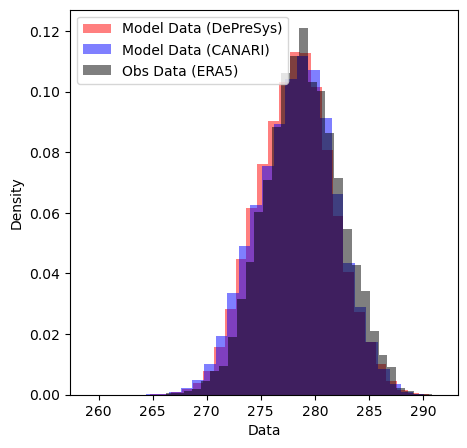

In [15]:
# Set up a figure
fig, ax = plt.subplots(figsize=(5, 5))


# Plot the normalized histogram of the model data in red
df_model_ondjfm['data'].plot(kind='hist', ax=ax, color='red', alpha=0.5, density=True, bins=30, label='Model Data (DePreSys)')

# plot the canari data in blue
model_df_full_canari_ONDJFM['tas'].plot(kind='hist', ax=ax, color='blue', alpha=0.5, density=True, bins=30, label='Model Data (CANARI)')

# Plot the normalized histogram of the obs data in black
df_obs_tas['data'].plot(kind='hist', ax=ax, color='black', alpha=0.5, density=True, bins=30, label='Obs Data (ERA5)')

# Add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Density')
ax.legend()

# Show the plot
plt.show()

In [16]:
df_obs_tas.head()

,time,data
0,1960-01-01,280.004414
1,1960-01-02,276.900436
2,1960-01-03,278.757843
3,1960-01-04,281.210861
4,1960-01-05,278.524161


In [17]:
# new column for temp in C
df_obs_tas['data_c'] = df_obs_tas['data'] - 273.15

In [18]:
# add a new column for temp c in the model data
df_model_ondjfm['data_c'] = df_model_ondjfm['data'] - 273.15

In [19]:
# add a new column for temp c in the canari data
model_df_full_canari_ONDJFM['tas_c'] = model_df_full_canari_ONDJFM['tas'] - 273.15

/tmp/ipykernel_2817678/3452988404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df_full_canari_ONDJFM['tas_c'] = model_df_full_canari_ONDJFM['tas'] - 273.15


In [20]:
model_df_full_canari_ONDJFM.head()

,member,time,tas,tas_c
0,1,1950-01-01,276.031406,2.881406
1,1,1950-01-02,279.126140,5.976140
2,1,1950-01-03,278.576242,5.426242
3,1,1950-01-04,279.686395,6.536395
4,1,1950-01-05,277.707194,4.557194


In [21]:
df_model_ondjfm.head()

,init_year,member,lead,data,data_c
330,1960,1,331,283.344633,10.194633
331,1960,1,332,284.247110,11.097110
332,1960,1,333,284.948156,11.798156
333,1960,1,334,284.529038,11.379038
334,1960,1,335,284.921268,11.771268


In [22]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

/tmp/ipykernel_2817678/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_2817678/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_2817678/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [23]:
# create a new column in df_model_ondjfm_wyear - effective_dec_year
df_model_ondjfm_wyear["effective_dec_year"] = df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]

In [24]:
df_model_ondjfm_wyear.head()

,init_year,member,lead,data,data_c,winter_year,effective_dec_year
330,1960,1,331,283.344633,10.194633,1,1961
331,1960,1,332,284.247110,11.097110,1,1961
332,1960,1,333,284.948156,11.798156,1,1961
333,1960,1,334,284.529038,11.379038,1,1961
334,1960,1,335,284.921268,11.771268,1,1961


In [25]:
# for df_obs_tas
# format 'time' as a datetime
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"])

# set as the index
df_obs_tas.set_index("time", inplace=True)

Now we want to plot the trend of the canari ensemble in comparison to the DePreSys ensemble, to see whether they are similar, or whether they look completely different.

Getting towards trying to verify whether our expectation for demand extremes is realistic - i.e., is it genuinely just very unlikely that we would see a 1962/1963 type winter again?

In [26]:
# create a new column in df_model_ondjfm_wyear - effective_dec_year
df_model_ondjfm_wyear["effective_dec_year"] = df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]

# preprocess the df_model_tas
df_model_tas_wyear = df_model_ondjfm_wyear.groupby(
    [
        "effective_dec_year",
        "member",
        "init_year",
    ]
).mean().reset_index()

In [27]:
df_model_tas_wyear.head()

,effective_dec_year,member,init_year,lead,data,data_c,winter_year
0,1961,1,1960,420.5,278.461009,5.311009,1.0
1,1961,2,1960,420.5,276.268232,3.118232,1.0
2,1961,3,1960,420.5,278.498982,5.348982,1.0
3,1961,4,1960,420.5,277.834329,4.684329,1.0
4,1961,5,1960,420.5,277.846542,4.696542,1.0


In [28]:
# head of the canari data
model_df_full_canari_ONDJFM.head()

,member,time,tas,tas_c
0,1,1950-01-01,276.031406,2.881406
1,1,1950-01-02,279.126140,5.976140
2,1,1950-01-03,278.576242,5.426242
3,1,1950-01-04,279.686395,6.536395
4,1,1950-01-05,277.707194,4.557194


In [29]:
# process canari data into winter means
model_df_canari_wyears = pd.DataFrame()

# Loop over the unique ensemble members
for member in tqdm(model_df_full_canari_ONDJFM["member"].unique()):
    # Loop over the years
    for year in model_df_full_canari_ONDJFM["time"].str.split("-").str[0].unique():
        # subset the data to the member
        df_this_member = model_df_full_canari_ONDJFM[model_df_full_canari_ONDJFM["member"] == member]

        # subset the data to the year and months [10, 11, 12]
        df_this_year = df_this_member[df_this_member["time"].str.split("-").str[0] == year]
        df_this_year_ond = df_this_year[df_this_year["time"].str.split("-").str[1].isin(["10", "11", "12"])]

        # df next year for the second half of the winter
        df_next_year = df_this_member[df_this_member["time"].str.split("-").str[0] == str(int(year) + 1)]
        df_next_year_jfm = df_next_year[df_next_year["time"].str.split("-").str[1].isin(["01", "02", "03"])]

        # concatenate the two dataframes
        df_winter_year = pd.concat([df_this_year_ond, df_next_year_jfm])

        # Set up a new dataframe
        df_this_year_mean = pd.DataFrame(
            {
                "effective_dec_year": [int(year)],
                "member": [member],
                "tas_ondjfm_mean": [df_winter_year["tas_c"].mean()],
            }
        )

        # Append to the new dataframe
        model_df_canari_wyears = pd.concat([model_df_canari_wyears, df_this_year_mean])

100%|██████████| 40/40 [01:25<00:00,  2.13s/it]


In [30]:
model_df_canari_wyears.tail()

,effective_dec_year,member,tas_ondjfm_mean
0,2010,40,4.914878
0,2011,40,6.526816
0,2012,40,4.993505
0,2013,40,5.732630
0,2014,40,6.923030


In [31]:
model_df_full_canari_ONDJFM.head()

,member,time,tas,tas_c
0,1,1950-01-01,276.031406,2.881406
1,1,1950-01-02,279.126140,5.976140
2,1,1950-01-03,278.576242,5.426242
3,1,1950-01-04,279.686395,6.536395
4,1,1950-01-05,277.707194,4.557194


In [32]:
# remove 2014 from the canari data
model_df_canari_wyears = model_df_canari_wyears[model_df_canari_wyears["effective_dec_year"] != 2014]

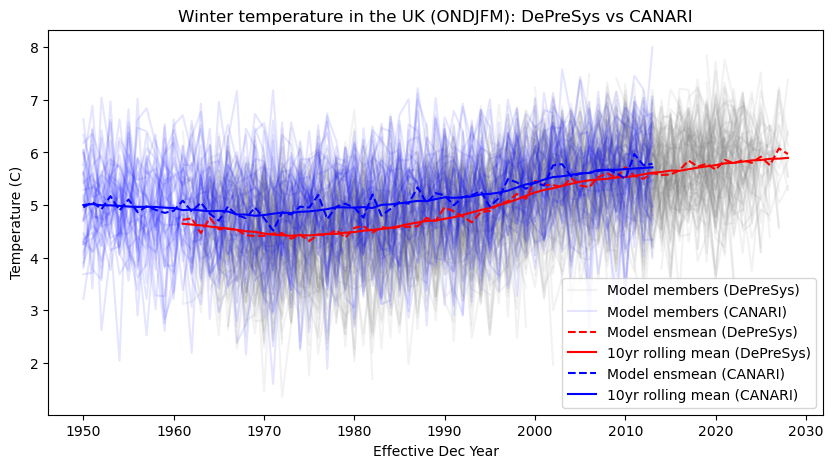

In [33]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# calculate the ensemble mean
model_ensmean = df_model_tas_wyear.groupby("effective_dec_year")["data_c"].mean()

# set up the unique years
years = np.unique(df_model_tas_wyear["effective_dec_year"])

# looop over the years
for i_year, init_year in enumerate(df_model_tas_wyear["init_year"].unique()):
    for j_member, member in enumerate(df_model_tas_wyear["member"].unique()):
        # subset the data
        df_model_tas_this = df_model_tas_wyear[
            (df_model_tas_wyear["init_year"] == init_year)
            & (df_model_tas_wyear["member"] == member)
        ]

        # plot the data
        if i_year == 0 and j_member == 0:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c"],
                color="grey",
                alpha=0.1,
                label="Model members (DePreSys)",
            )
        else:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c"],
                color="grey",
                alpha=0.1,
            )

# loop ovr the unique members in the canari ensemble
for m, member in enumerate(model_df_canari_wyears["member"].unique()):
    # subset the data
    df_canari_this = model_df_canari_wyears[model_df_canari_wyears["member"] == member]

    if m == 0:
        # plot the data
        plt.plot(
            df_canari_this["effective_dec_year"],
            df_canari_this["tas_ondjfm_mean"],
            color="blue",
            alpha=0.1,
            label="Model members (CANARI)",
        )
    else:
        # plot the data
        plt.plot(
            df_canari_this["effective_dec_year"],
            df_canari_this["tas_ondjfm_mean"],
            color="blue",
            alpha=0.1,
        )

# plot the ensemble mean
plt.plot(
    years,
    model_ensmean,
    color="red",
    label="Model ensmean (DePreSys)",
    linestyle="--",
)

# calculate the rolling mean for depresys
model_ensmean_rolling = model_ensmean.rolling(window=10, center=True, min_periods=1).mean()

# plot the rolling mean
plt.plot(
    years,
    model_ensmean_rolling,
    color="red",
    label="10yr rolling mean (DePreSys)",
)

# plot the canari ensemble mean
plt.plot(
    model_df_canari_wyears.groupby("effective_dec_year")["tas_ondjfm_mean"].mean(),
    color="blue",
    label="Model ensmean (CANARI)",
    linestyle="--",
)

# Calculate the rolling mean for canari
model_canari_ensmean_rolling = model_df_canari_wyears.groupby("effective_dec_year")["tas_ondjfm_mean"].mean().rolling(
    window=10, center=True, min_periods=1
).mean()

# plot the rolling mean
plt.plot(
    model_canari_ensmean_rolling,
    color="blue",
    label="10yr rolling mean (CANARI)",
)

# Add labels and legend
plt.xlabel("Effective Dec Year")

plt.ylabel("Temperature (C)")

plt.legend()

# Set a title
plt.title("Winter temperature in the UK (ONDJFM): DePreSys vs CANARI")

# Show the plot
plt.show()

Now we want to apply this detrending to the canari data


In [34]:
# drop years containing 2014 from canar
model_df_full_canari_ONDJFM = model_df_full_canari_ONDJFM[model_df_full_canari_ONDJFM["time"].str.split("-").str[0] != "2014"]

In [35]:
sys.path.append("/home/users/benhutch/unseen_functions/")
import functions as func

In [36]:
import importlib
importlib.reload(func)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [37]:
df_model_tas.head()

,init_year,member,lead,data
0,1960,1,1,283.904326
1,1960,1,2,281.653069
2,1960,1,3,280.558694
3,1960,1,4,280.931852
4,1960,1,5,280.171699


In [38]:
# new column for data_c in the model data
df_model_tas["data_c"] = df_model_tas["data"] - 273.15

In [39]:
model_df_canari_wyears.head()

,effective_dec_year,member,tas_ondjfm_mean
0,1950,1,4.059286
0,1951,1,5.015300
0,1952,1,5.589766
0,1953,1,5.886735
0,1954,1,4.233933


In [40]:
model_df, obs_df, canari_df = func.apply_detrend_rolling(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="effective_dec_year",
    canari_df=model_df_full_canari_ONDJFM,
    canari_df_wmeans=model_df_canari_wyears,
    canari_val_name="tas_c",
    canari_time_name="time",
)

(10753,)
obs slope  0.02940253691106833
obs intercept  -52.740204734374664
(10753,)


/home/users/benhutch/unseen_functions/functions.py:12860: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_df_ondjfm = obs_df.shift(periods=-3, freq=pd.DateOffset(months=3)).resample("A").mean()


In [41]:
canari_df.tail()

,member,time,tas,tas_c,tas_c_dt
921595,40,2013-12-26,278.410715,5.260715,5.260715
921596,40,2013-12-27,277.492975,4.342975,4.342975
921597,40,2013-12-28,277.118045,3.968045,3.968045
921598,40,2013-12-29,277.511657,4.361657,4.361657
921599,40,2013-12-30,277.984704,4.834704,4.834704


In [42]:
model_df.head()

,init_year,member,lead,data,data_c,winter_year,effective_dec_year,data_c_dt
330,1960,1,331,283.344633,10.194633,1,1961,11.446461
331,1960,1,332,284.247110,11.097110,1,1961,12.348938
332,1960,1,333,284.948156,11.798156,1,1961,13.049984
333,1960,1,334,284.529038,11.379038,1,1961,12.630866
334,1960,1,335,284.921268,11.771268,1,1961,13.023096


In [43]:
# df_model_tas = model_df

# preprocess the df_model_tas
df_model_tas_wyear = model_df.groupby(
    [
        "effective_dec_year",
        "member",
        "init_year",
    ]
).mean().reset_index()

In [44]:
df_obs_tas_ondjfm = obs_df.shift(
    periods=-3,
    freq=pd.DateOffset(months=3)
).resample("A").mean()

/tmp/ipykernel_2817678/3974717623.py:4: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ).resample("A").mean()


In [45]:
df_model_tas_wyear.head()

,effective_dec_year,member,init_year,lead,data,data_c,winter_year,data_c_dt
0,1961,1,1960,420.5,278.461009,5.311009,1.0,6.562837
1,1961,2,1960,420.5,276.268232,3.118232,1.0,4.370060
2,1961,3,1960,420.5,278.498982,5.348982,1.0,6.600810
3,1961,4,1960,420.5,277.834329,4.684329,1.0,5.936157
4,1961,5,1960,420.5,277.846542,4.696542,1.0,5.948370


In [46]:
canari_df.head()

,member,time,tas,tas_c,tas_c_dt
0,1,1950-01-01,276.031406,2.881406,3.597189
1,1,1950-01-02,279.126140,5.976140,6.691924
2,1,1950-01-03,278.576242,5.426242,6.142026
3,1,1950-01-04,279.686395,6.536395,7.252178
4,1,1950-01-05,277.707194,4.557194,5.272977


In [47]:
# add a new column in the canari data for the effective_dec_year
# time is a string
# if the month is in 01, 02, 03 - then effective dec is the previous year
# if the month is in 10, 11, 12 - then effective dec is the current year
# if canari_df["time"].str.split("-").str[1].isin(["01", "02", "03"]).all():
#     canari_df["effective_dec_year"] = canari_df["time"].str.split("-").str[0].astype(int) - 1
# elif canari_df["time"].str.split("-").str[1].isin(["10", "11", "12"]).all():
#     canari_df["effective_dec_year"] = canari_df["time"].str.split("-").str[0].astype(int)

# import pandas as pd

# Define the custom function to determine the effective_dec_year
def determine_effective_dec_year(row):
    year = int(row["time"].split("-")[0])
    month = row["time"].split("-")[1]
    if month in ["01", "02", "03"]:
        return year - 1
    elif month in ["10", "11", "12"]:
        return year
    else:
        return None  # or some default value if needed

# Apply the function to each row
canari_df["effective_dec_year"] = canari_df.apply(determine_effective_dec_year, axis=1)

In [48]:
canari_df.tail()

,member,time,tas,tas_c,tas_c_dt,effective_dec_year
921595,40,2013-12-26,278.410715,5.260715,5.260715,2013
921596,40,2013-12-27,277.492975,4.342975,4.342975,2013
921597,40,2013-12-28,277.118045,3.968045,3.968045,2013
921598,40,2013-12-29,277.511657,4.361657,4.361657,2013
921599,40,2013-12-30,277.984704,4.834704,4.834704,2013


In [58]:
df_model_tas.head()

,init_year,member,lead,data,data_c
0,1960,1,1,283.904326,10.754326
1,1960,1,2,281.653069,8.503069
2,1960,1,3,280.558694,7.408694
3,1960,1,4,280.931852,7.781852
4,1960,1,5,280.171699,7.021699


In [59]:
# # set up a figure
# fig, ax = plt.subplots(figsize=(10, 5))

# # Calculate the model ensmean
# model_ensmean = df_model_tas.groupby("effective_dec_year")["data_c"].mean()
# model_ensmean_dt = df_model_tas.groupby("effective_dec_year")["data_c_dt"].mean()

# # calculate the ensemble mean for canari data
# canari_ensmean = canari_df.groupby("effective_dec_year")["tas_c"].mean()[1:-1]
# canari_ensmean_dt = canari_df.groupby("effective_dec_year")["tas_c_dt"].mean()[1:-1]

# # unqiue effective dec years
# unique_years = df_model_tas["effective_dec_year"].unique()

# # extract the unique canari years
# unique_canari_years = canari_df["effective_dec_year"].unique()[1:-1]

# # print the shape of the model ensmean
# print(model_ensmean.shape)
# print(unique_years.shape)

# # loop over the unqiue members
# for i, member in enumerate(df_model_tas["member"].unique()):
#     # loop over the unique init years
#     for j, init_year in enumerate(df_model_tas["init_year"].unique()):
#         # subset the data
#         df_model_tas_this = df_model_tas_wyear[
#             (df_model_tas_wyear["member"] == member) & (df_model_tas_wyear["init_year"] == init_year)
#         ]


#         if i == 0 and j == 0:
#             # plot the data
#             plt.plot(
#                 df_model_tas_this["effective_dec_year"],
#                 df_model_tas_this["data_c_dt"],
#                 color="grey",
#                 alpha=0.1,
#                 label="Model ens dtr",
#             )
#         else:
#             # plot the data
#             plt.plot(
#                 df_model_tas_this["effective_dec_year"],
#                 df_model_tas_this["data_c_dt"],
#                 color="grey",
#                 alpha=0.1,
#             )

# # # plot the model ensmean not detrended
# plt.plot(
#     unique_years,
#     model_ensmean,
#     color="red",
#     label="Model ensmean",
#     linestyle="--",
# )

# # # plot the obs data not detrended
# plt.plot(
#     df_obs_tas_ondjfm.index.year,
#     df_obs_tas_ondjfm["data_c"],
#     color="black",
#     label="Obs Data",
#     linestyle="--",
# )

# # plot the canari data not detrended
# plt.plot(
#     unique_canari_years,
#     canari_ensmean,
#     color="blue",
#     label="Model ensmean (CANARI)",
#     linestyle="--",
# )

# # plot the model ensmean detrended
# plt.plot(
#     unique_years,
#     model_ensmean_dt,
#     color="red",
#     label="Model ensmean dtr",
# )

# # plot the obs data detrended
# plt.plot(
#     df_obs_tas_ondjfm.index.year,
#     df_obs_tas_ondjfm["data_c_dt"],
#     color="black",
#     label="Obs dtr",
# )

# # plot the canari data detrended
# plt.plot(
#     unique_canari_years,
#     canari_ensmean_dt,
#     color="blue",
#     label="Model ensmean dtr (CANARI)",
# )

# # plot a solid horizontal line 
# # for the minimum value of the detrended obs
# plt.axhline(
#     y=df_obs_tas_ondjfm["data_c_dt"].min(),
#     color="black",
# )

# # plot a dashed horizontal line
# # for the minimum value of the detrended obs
# plt.axhline(
#     y=df_obs_tas_ondjfm["data_c"].min(),
#     color="black",
#     linestyle="--",
# )

# # include titles for the horixzontak lines
# plt.text(
#     x=unique_years[-1],
#     y=df_obs_tas_ondjfm["data_c_dt"].min(),
#     s="Obs min dtr",
#     color="black",
#     verticalalignment="bottom",
#     horizontalalignment="right",
# )

# plt.text(
#     x=unique_years[-1],
#     y=df_obs_tas_ondjfm["data_c"].min() + 0.25,
#     s="Obs min",
#     color="black",
#     verticalalignment="top",
#     horizontalalignment="right",
# )

# # Add labels and legend
# # include horizontal anad vertical gridlines
# ax.set_ylabel("Temperature (C)")

# # Add labels and legend
# ax.grid(which="both", linewidth=0.5)

# # Set a title
# ax.set_title("UK ONDJFM Temperature (1960-2018)")

# # include the legend centred under the title
# ax.legend(loc="upper center", ncol=3)

### CANARI fidelity ###

Compare the fidelity of canari to DePreSys. Should be broadly similar.

In [50]:
df_obs_tas

,data,data_c,data_c_dt
time,,,
1960-01-01,280.004414,6.854414,8.559761
1960-01-02,276.900436,3.750436,5.455783
1960-01-03,278.757843,5.607843,7.313191
1960-01-04,281.210861,8.060861,9.766208
1960-01-05,278.524161,5.374161,7.079509
...,...,...,...
2018-12-27,280.410430,7.260430,7.260430
2018-12-28,280.654895,7.504895,7.504895
2018-12-29,281.870591,8.720591,8.720591


In [51]:
# reset the index of df_obs_tas
df_obs_tas.reset_index(inplace=True)

# esnure that time is a datetime
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"])

In [52]:
df_obs_tas.tail()

,time,data,data_c,data_c_dt
10748,2018-12-27,280.410430,7.260430,7.260430
10749,2018-12-28,280.654895,7.504895,7.504895
10750,2018-12-29,281.870591,8.720591,8.720591
10751,2018-12-30,282.060577,8.910577,8.910577
10752,2018-12-31,282.126349,8.976349,8.976349


In [53]:
# create a new column for the effective_dec_year in df_obs_tas
# write a function to determine the effective_dec_year
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
# apply the function to each row
df_obs_tas["effective_dec_year"] = df_obs_tas.apply(determine_effective_dec_year, axis=1)

In [54]:
# get rid of first and last effective dec years in the obs
df_obs_tas_subset = df_obs_tas[(df_obs_tas["effective_dec_year"] != 1959) & (df_obs_tas["effective_dec_year"] != 2018)]

In [55]:
# set up the n_winters as the number of unique effective_dec_years in the obs]
n_winters_obs = df_obs_tas_subset["effective_dec_year"].nunique()

# print the number of winters
print(n_winters_obs)

58


In [56]:
# reload functions
import importlib
importlib.reload(func)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [66]:
df_obs_tas["effective_dec_year"].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017])

In [63]:
# remove the first and last effective dec years from the obs
df_obs_tas = df_obs_tas[(df_obs_tas["effective_dec_year"] != 1959) & (df_obs_tas["effective_dec_year"] != 2018)]

In [62]:
model_df["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028])

In [64]:
# subset model_df to the same effective dec years as the obs
model_df_subset = model_df[model_df["effective_dec_year"].isin(df_obs_tas["effective_dec_year"].unique())]

In [69]:
df_obs_tas.columns

Index(['time', 'data', 'data_c', 'data_c_dt', 'effective_dec_year'], dtype='object')

the number of unique winters is:  58
the unique times are:  [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017]
Number of days in a model winter: 180
Number of days to resample for: 10440


Calculating bootstrap statistics:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [01:09<00:00, 14.31it/s]


(1000,)
shape of obs df obs_val_name:  (10570,)
Obs stats: 
{'mean': np.float64(6.590095570796722), 'sigma': np.float64(3.445128605684928), 'skew': np.float64(-0.006036263537770468), 'kurt': np.float64(-0.14491195615451957)}
Model stats full: 
{'mean': np.float64(5.904398750592939), 'sigma': np.float64(3.467597311005883), 'skew': np.float64(-0.040824476616063816), 'kurt': np.float64(-0.1512769750798264)}


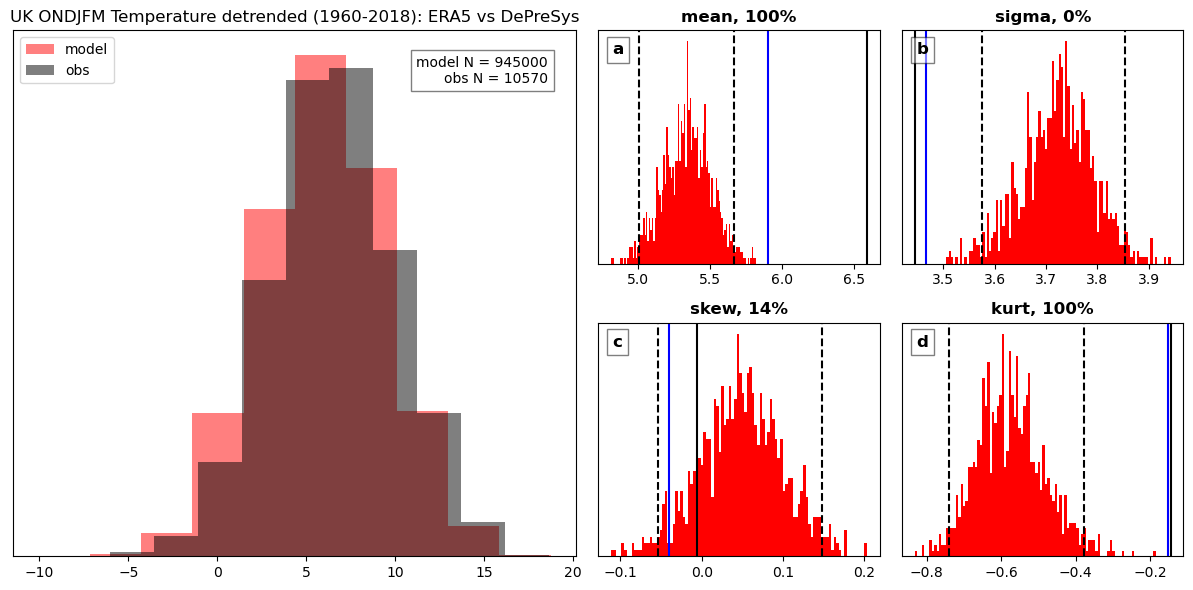

In [70]:
# PLot the fidelity of obs detrended temp against depresys
func.plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=model_df_subset,
    obs_val_name="data_c_dt",
    model_val_name="data_c_dt",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="winter_year",
    nboot=1000,
    figsize=(12, 6),
    title="UK ONDJFM Temperature detrended (1960-2018): ERA5 vs DePreSys",
    fname_prefix="UK_ONDJFM_Temperature_detrended_1960-2018_ERA5_vs_DePreSys",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [ ]:
# subset canari_df  to effective_dec_year  = 1960
canari_df_1960 = canari_df[canari_df["effective_dec_year"] == 1960]

In [ ]:
canari_df_1960

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [73]:
# exclude 1949 and 2013 from the canari data
canari_df_subset = canari_df[(canari_df["effective_dec_year"] != 1949) & (canari_df["effective_dec_year"] != 2013)]

In [76]:
np.unique(df_obs_tas_subset["effective_dec_year"])

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [77]:
np.unique(canari_df_subset["effective_dec_year"])

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012])

In [75]:
# start canari_df_subset from 1960
canari_df_subset = canari_df_subset[canari_df_subset["effective_dec_year"] >= 1960]

# limit df_obs_tas to the same years as canari_df_subset
df_obs_tas_subset = df_obs_tas[df_obs_tas["effective_dec_year"].isin(canari_df_subset["effective_dec_year"].unique())]

In [ ]:
# # throw awaya effective dec years 1959, 2013 and onwards
# # from the obs data
# df_obs_tas_subset = df_obs_tas[(df_obs_tas["effective_dec_year"] != 1959)]

# # Remove rows where effective_dec_year is 2013 or later
# df_obs_tas_subset = df_obs_tas_subset[df_obs_tas_subset["effective_dec_year"] < 2013]

# # Similarly, remove rows where effective_dec_year is 2013 or later from canari_df_subset
# canari_df_subset = canari_df_subset[canari_df_subset["effective_dec_year"] < 2013]

# # remove the years 1959 and below from canari_df_subset
# canari_df_subset = canari_df_subset[canari_df_subset["effective_dec_year"] > 1959]

the number of unique winters is:  53
the unique times are:  [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Number of days in a model winter: 180
Number of days to resample for: 9540


Calculating bootstrap statistics:   1%|          | 10/1000 [00:00<00:23, 42.49it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:23<00:00, 42.52it/s]


(1000,)
shape of obs df obs_val_name:  (9659,)
Obs stats: 
{'mean': np.float64(6.582359510136047), 'sigma': np.float64(3.468690764280091), 'skew': np.float64(-0.02328445251063358), 'kurt': np.float64(-0.14833951094605258)}
Model stats full: 
{'mean': np.float64(5.717554196010888), 'sigma': np.float64(3.588513240464097), 'skew': np.float64(-0.12582479053368945), 'kurt': np.float64(-0.18739685769980552)}


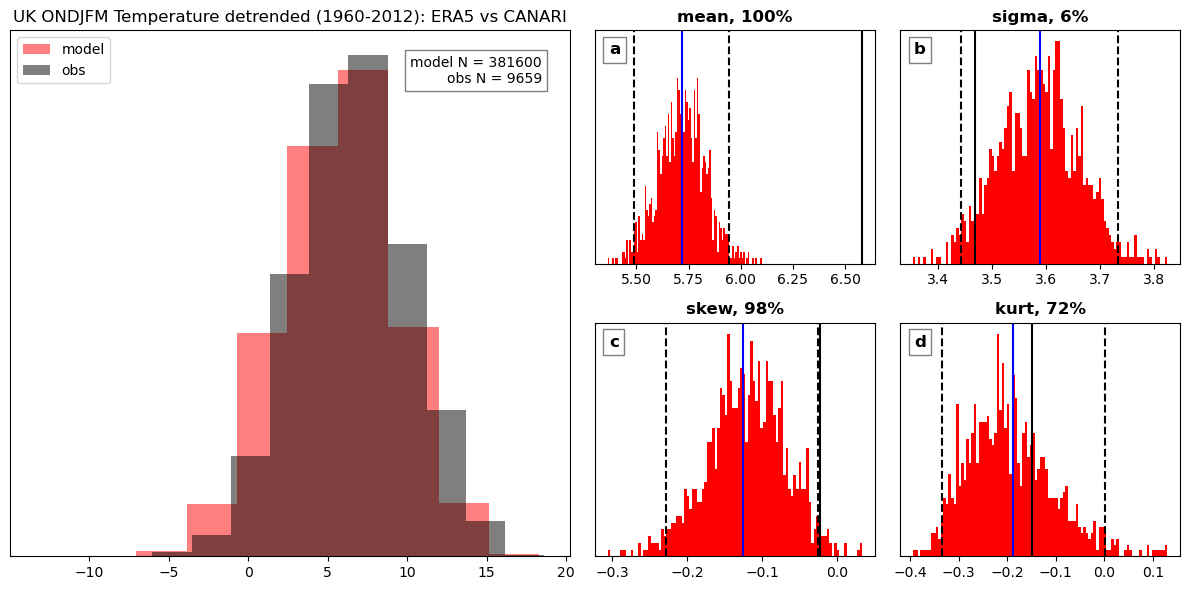

In [78]:
# same but for canari
func.plot_distributions_fidelity(
    obs_df=df_obs_tas_subset,
    model_df=canari_df_subset,
    obs_val_name="data_c_dt",
    model_val_name="tas_c_dt",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name=None,
    nboot=1000,
    figsize=(12, 6),
    title="UK ONDJFM Temperature detrended (1960-2012): ERA5 vs CANARI",
    fname_prefix="UK_ONDJFM_Temperature_detrended_1960-2012_ERA5_vs_CANARI",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

NOw we want to count the number of cold days in a given winter.

First bias correct the data

In [79]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import bc_linear_scaling

# apply the bias correction
model_df_subset_bc = bc_linear_scaling(
    obs_df=df_obs_tas_subset,
    model_df=model_df_subset,
    obs_val_name="data_c_dt",
    model_val_name="data_c_dt",
)

# apply the bias correction
canari_df_subset_bc = bc_linear_scaling(
    obs_df=df_obs_tas_subset,
    model_df=canari_df_subset,
    obs_val_name="data_c_dt",
    model_val_name="tas_c_dt",
)

/home/users/benhutch/unseen_functions/functions.py:6020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[model_val_name + "_bc"] = model_df[model_val_name] - bias


In [80]:
canari_df_subset_bc.columns

Index(['member', 'time', 'tas', 'tas_c', 'tas_c_dt', 'effective_dec_year',
       'tas_c_dt_bc'],
      dtype='object')

In [81]:
model_df_subset_bc.columns

Index(['init_year', 'member', 'lead', 'data', 'data_c', 'winter_year',
       'effective_dec_year', 'data_c_dt', 'data_c_dt_bc'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of daily UK temperature (1960-2012): ERA5 vs DePreSys vs CANARI')

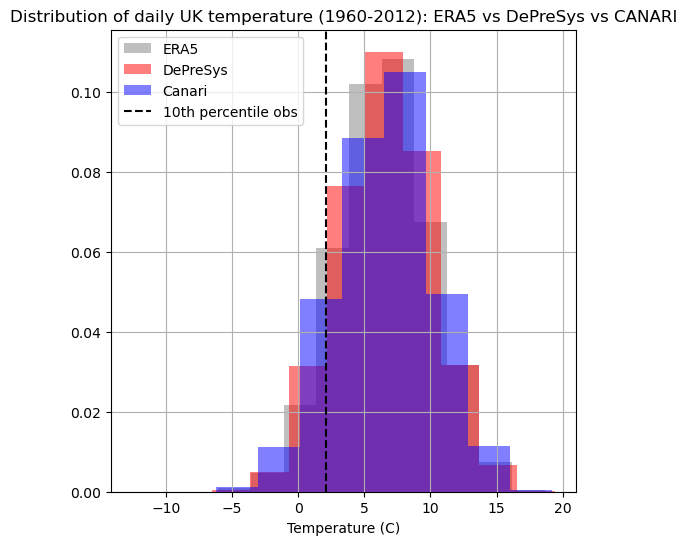

In [83]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the observed north sea wind speed
df_obs_tas_subset["data_c_dt"].hist(
    ax=ax, alpha=0.5, label="ERA5", color="gray", density=True
)

# Plot a histogram of the model uk temperature
model_df_subset_bc["data_c_dt_bc"].hist(
    ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# # plot a histogram of the canari data
canari_df_subset_bc["tas_c_dt_bc"].hist(
    ax=ax, alpha=0.5, label="Canari", color="blue", density=True
)

# # plot the mean of the obs
# ax.axvline(df_obs["UK_demand_dt"].mean(), color="black", linestyle="--", label="mean obs")

# # plot the mean of the model
# ax.axvline(
#     df_model["UK_demand_dt"].mean(), color="black", linestyle="-", label="mean model"
# )

# # plot a horizontal line for the 10th percentile of the obs
ax.axvline(
    df_obs_tas_subset["data_c_dt"].quantile(0.1),
    color="black",
    linestyle="--",
    label="10th percentile obs",
)

# # # print the range of the central 95th percentile
# print(f"Central 95th percentile: {df_obs_sfcWind_uk['data'].quantile(0.025)} to {df_obs_sfcWind_uk['data'].quantile(0.975)}")

# # # print the difference between the 2.5th and 97.5th percentiles
# print(f"95th percentile obs: {df_obs_sfcWind_uk['data'].quantile(0.975) - df_obs_sfcWind_uk['data'].quantile(0.025)}")

# include a legend in the top left
ax.legend(loc="upper left")

# include an xlabel
ax.set_xlabel("Temperature (C)")

# include a title
ax.set_title("Distribution of daily UK temperature (1960-2012): ERA5 vs DePreSys vs CANARI")

In [84]:
df_obs_tas_subset.head()

,time,data,data_c,data_c_dt,effective_dec_year
91,1960-10-01,283.417183,10.267183,11.972531,1960
92,1960-10-02,286.091771,12.941771,14.647118,1960
93,1960-10-03,286.002938,12.852938,14.558285,1960
94,1960-10-04,284.977745,11.827745,13.533092,1960
95,1960-10-05,284.634095,11.484095,13.189442,1960


In [85]:
# set time as the index
df_obs_tas_subset.set_index("time", inplace=True)

In [86]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.unique(df_obs_tas_subset["effective_dec_year"])

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
no_exceedance_days_demand = []
severity_index_demand = []

# Same for wind speed
no_undershoot_days_wind = []
severity_index_wind = []

# # Same for demand net wind
no_exceedance_days_demand_net_wind = []
severity_index_demand_net_wind = []

# 92 just chosen to be in line with demand net wind
# 87th percentile for demand ~ 45 GW
# all_winters_high_demand = np.percentile(df_obs["UK_demand_dt"], 90)

# 94th percentile for demand net wind ~ 40 GW identified by Ben Sloman as being
# challenging
# all_winters_high_DnW = np.percentile(df_obs["demand_dt_net_wind"], 90)

# 12th percentile of wind generation ~ 5 GW
# Which is pretty low during the winter
# all_winters_low_wind = np.percentile(df_ch["wind_gen"], 10)
# all_winters_low_wind_uk = np.percentile(df_obs_tas_subset["data"], 10)
# all_winters_low_wind_ns = np.percentile(df_obs_sfcWind_ns["data"], 10)
all_winters_cold_days_uk = np.percentile(df_obs_tas_subset["data_c_dt"], 10)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df_this = df_obs_tas_subset.loc[winter_start:winter_end]
    # df_ch_this = df_ch.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df_this.index:
        print("Dropping 29th Feb")
        df_this = df_this.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    # mask_demand = df["UK_demand_dt"] > all_winters_high_demand
    # mask_DnW = df["demand_dt_net_wind"] > all_winters_high_DnW
    # mask_wind = df_ch_this["wind_gen"] < all_winters_low_wind
    mask_wind_uk = df_this["data_c_dt"] < all_winters_cold_days_uk

    # # calculate the severity index
    # severity_index_demand_this = (
    #     df["UK_demand_dt"][mask_demand] - all_winters_high_demand
    # ).sum()
    # severity_index_demand_net_wind_this = (
    #     df["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
    # ).sum()
    # severity_index_wind_this = (
    #     all_winters_low_wind - df_ch_this["wind_gen"][mask_wind]
    # ).sum()

    # # append these to the list
    # severity_index_demand.append(severity_index_demand_this)
    # severity_index_demand_net_wind.append(severity_index_demand_net_wind_this)
    # severity_index_wind.append(severity_index_wind_this)

    # calculate the no. exceedance days
    # no_exceedance_days_demand_this = mask_demand.sum()
    # no_exceedance_days_demand_net_wind_this = mask_DnW.sum()
    # no_undershoot_days_wind_this = mask_wind.sum()
    no_low_wind_days_uk = mask_wind_uk.sum()

    # append these to the list
    # no_exceedance_days_demand.append(no_exceedance_days_demand_this)
    # no_exceedance_days_demand_net_wind.append(no_exceedance_days_demand_net_wind_this)
    no_undershoot_days_wind.append(no_low_wind_days_uk)

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "no_cold_days": no_undershoot_days_wind,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [87]:
df_exceedance_days_obs_uk_temp = df_exceedance_days_obs.copy()

<Axes: >

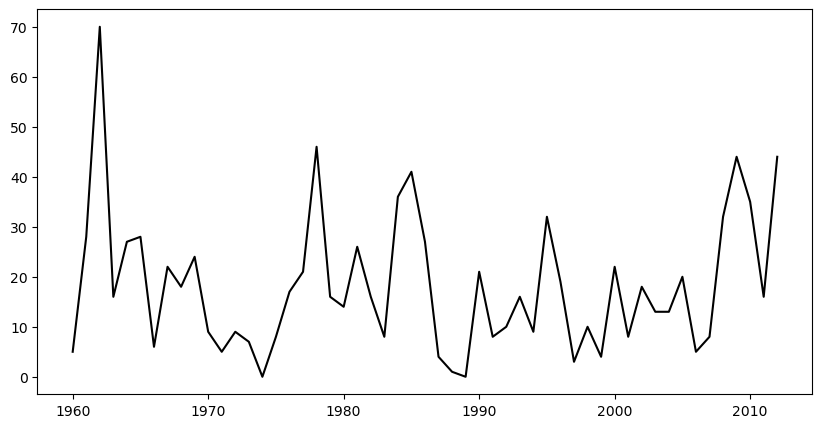

In [88]:
# set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
df_exceedance_days_obs["no_cold_days"].plot(ax=ax, color="black", label="ERA5")

In [89]:
# Process the same for the model data
# Extract the unique init years
init_years = model_df_subset_bc["init_year"].unique()
members = model_df_subset_bc["member"].unique()
winter_years = model_df_subset_bc["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for demand net wind
model_severity_index_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for wind generation
model_severity_index_wind = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_undershoot_days_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = model_df_subset_bc[
                (model_df_subset_bc["init_year"] == i_year)
                & (model_df_subset_bc["member"] == member)
                & (model_df_subset_bc["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            # mask_demand = df_this["UK_demand_dt"] > all_winters_high_demand
            # mask_DnW = df_this["demand_dt_net_wind"] > all_winters_high_DnW
            mask_temp = df_this["data_c_dt_bc"] < all_winters_cold_days_uk

            # # calculate the severity index
            # model_severity_index_demand[i, j, k] = (
            #     df_this["UK_demand_dt"][mask_demand] - all_winters_high_demand
            # ).sum()
            # model_severity_index_demand_net_wind[i, j, k] = (
            #     df_this["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
            # ).sum()
            # model_severity_index_wind[i, j, k] = (
            #     all_winters_low_wind - df_this["wind_gen_sigmoid"][mask_wind]
            # ).sum()

            # # calculate the no. exceedance days
            # model_no_exceedance_days_demand[i, j, k] = mask_demand.sum()
            # model_no_exceedance_days_demand_net_wind[i, j, k] = mask_DnW.sum()
            model_no_undershoot_days_wind[i, j, k] = mask_temp.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "no_cold_days": [mask_temp.sum()],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [90]:
# make a copy of df_model_exceedance
df_model_exceedance_uk_temp = df_model_exceedance.copy()

In [91]:
# add the effective_dec_year to the df_model_exceedance
df_model_exceedance["effective_dec_year"] = df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]

In [92]:
df_model_exceedance.head()

,init_year,member,winter_year,no_cold_days,effective_dec_year
0,1960,1,1,7,1961
0,1960,1,2,29,1962
0,1960,1,3,35,1963
0,1960,1,4,14,1964
0,1960,1,5,24,1965


In [93]:
# do the same but for canari
# extrcat the unique effective_dec_years
dec_years = canari_df_subset_bc["effective_dec_year"].unique()
members = canari_df_subset_bc["member"].unique()

# array for the no undershoot days wind
model_no_undershoot_days_wind_canari = np.zeros([len(dec_years), len(members)])

# set up an empty canari_df_subset_bc
df_model_exceedance_canari = pd.DataFrame()

# loop over the dec years
for i, dec_year in enumerate(dec_years):
    for j, member in enumerate(members):
        # constrain to the dec year and member
        df_this = canari_df_subset_bc[
            (canari_df_subset_bc["effective_dec_year"] == dec_year)
            & (canari_df_subset_bc["member"] == member)
        ]

        # apply a boolean mask to the demand net wind value
        # which is true where the demand net wind is greater than the 80% tile value
        mask_temp = df_this["tas_c_dt_bc"] < all_winters_cold_days_uk

        # calculate the no. undershoot days
        model_no_undershoot_days_wind_canari[i, j] = mask_temp.sum()

        # Set up the canari_df_subset_bc
        df_this_exceedance = pd.DataFrame(
            {
                "effective_dec_year": [dec_year],
                "member": [member],
                "no_cold_days": [mask_temp.sum()],
            }
        )

        # Append to the canari_df_subset_bc
        df_model_exceedance_canari = pd.concat([df_model_exceedance_canari, df_this_exceedance])

In [95]:
df_model_exceedance_canari.tail()

,effective_dec_year,member,no_cold_days
0,2012,36,13
0,2012,37,24
0,2012,38,6
0,2012,39,5
0,2012,40,37


In [104]:
# remove effective dec years 2018 onwards from the model
df_model_exceedance = df_model_exceedance[df_model_exceedance["effective_dec_year"] < 2018]

The worst event occurs in the year: 1962
The no. days for the worst event is: 70
Bad events have high values
The chance of a very bad event is: 0.09523809523809523%
The chance of a very bad event is: 1 in 1050 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_cold_days_model-no_cold_days_quantile-0.8_solid-max_dot_plot_2025-01-20-17-49-46.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_cold_days_model-no_cold_days_quantile-0.8_solid-max_dot_plot_2025-01-20-17-49-46.pdf


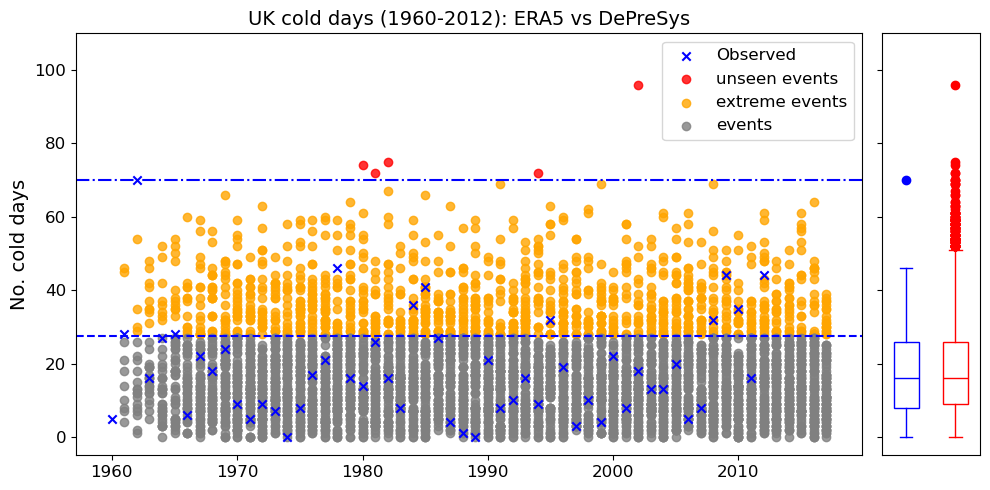

In [105]:
func.dot_plot(
    obs_df=df_exceedance_days_obs_uk_temp,
    model_df=df_model_exceedance,
    obs_val_name="no_cold_days",
    model_val_name="no_cold_days",
    model_time_name="effective_dec_year",
    ylabel="No. cold days",
    title="UK cold days (1960-2012): ERA5 vs DePreSys",
    ylims=(-5, 110),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

The worst event occurs in the year: 1962
The no. days for the worst event is: 70
Bad events have high values
The chance of a very bad event is: 0.33018867924528306%
The chance of a very bad event is: 1 in 303 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_cold_days_model-no_cold_days_quantile-0.8_solid-max_dot_plot_2025-01-20-17-50-42.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_cold_days_model-no_cold_days_quantile-0.8_solid-max_dot_plot_2025-01-20-17-50-42.pdf


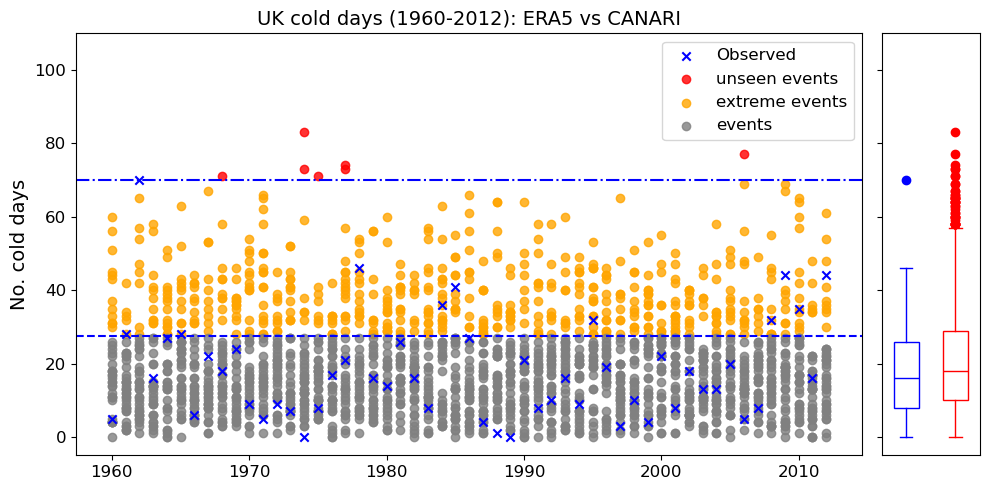

In [106]:
# do the same for canari
func.dot_plot(
    obs_df=df_exceedance_days_obs_uk_temp,
    model_df=df_model_exceedance_canari,
    obs_val_name="no_cold_days",
    model_val_name="no_cold_days",
    model_time_name="effective_dec_year",
    ylabel="No. cold days",
    title="UK cold days (1960-2012): ERA5 vs CANARI",
    ylims=(-5, 110),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [ ]:
# # Define a function for applying detrend
# # based on rolling mean of ensemble mean
# def apply_detrend_rolling(
#     obs_df: pd.DataFrame,
#     model_df: pd.DataFrame,
#     obs_val_name: str,
#     model_val_name: str,
#     obs_time_name: str,
#     model_time_name: str,
#     model_iyear_name: str = "init_year",
#     model_member_name: str = "member",
#     model_lead_name: str = "lead",
#     window_years: int = 10,
#     centered: bool = True,
#     min_periods: int = 1,
# ) -> pd.DataFrame:
#     """
#     Apply detrending to model data based on rolling mean of ensemble mean.

#     Args:
#     =====

#         obs_df: pd.DataFrame
#             DataFrame containing the observations.
#         model_df: pd.DataFrame
#             DataFrame containing the model data.
#         obs_val_name: str
#             Name of the column in obs_df containing the values.
#         model_val_name: str
#             Name of the column in model_df containing the values.
#         obs_time_name: str
#             Name of the column in obs_df containing the time values.
#         model_time_name: str
#             Name of the column in model_df containing the time values.
#         model_iyear_name: str
#             Name of the column in model_df containing the initialization year values.
#         model_member_name: str
#             Name of the column in model_df containing the member values.
#         model_lead_name: str
#             Name of the column in model_df containing the lead values.
#         window_years: int
#             Length of the rolling window in years.
#         centered: bool
#             Whether to use a centered window.
#         min_periods: int
#             Minimum number of periods to include in the calculation.

#     Returns:
#     ========

#         pd.DataFrame
#             DataFrame containing the detrended model data.
#     """
    

#     # Make a copy of the model df
#     model_df_copy = model_df.copy()

#     # Calculate the model ensemble mean
#     model_ensmean = model_df_copy.groupby(
#         model_time_name
#     )[model_val_name].mean()

#     # Calculate the rolling mean of the ensemble mean
#     trend_line = model_ensmean.rolling(
#         window=window_years,
#         center=centered,
#         min_periods=min_periods
#     ).mean()

#     # Extract the final point on the trend line
#     final_trend_point = trend_line.iloc[-1]

#     # Set up a new column in the model df
#     model_df[model_val_name + "_dt"] = model_df[model_val_name] - trend_line.loc[model_df[model_time_name].values].values + final_trend_point

#     # assert that obs_time_name is the index in the obs df
#     assert obs_time_name == obs_df.index.name, "obs_time_name must be the index in the obs_df"

#     # print(trend_line)

#     # extend trend line back to 1960
#     # by making 1960 the same value as first value in trend line
#     trend_line.loc[1960] = trend_line.iloc[0]

#     # Detrend the obs data
#     obs_df[obs_val_name + "_dt"] = obs_df[obs_val_name] - trend_line.loc[obs_df.index.year].values + final_trend_point

#     # Return the detrended model data
#     return model_df, obs_df


Fit a seperate trend to the observations.

In [ ]:
df_obs_tas.head()

,data,data_c
time,,
1960-01-01,280.004414,6.854414
1960-01-02,276.900436,3.750436
1960-01-03,278.757843,5.607843
1960-01-04,281.210861,8.060861
1960-01-05,278.524161,5.374161


In [ ]:
# # Set up a figure
# fig, ax = plt.subplots(figsize=(10, 5))

# # Plot the standard observations in grey
# plt.plot(df_obs_tas.index, df_obs_tas["data_c"], color='grey', label='Observed Data')

# # # set time as the index
# # df_obs_tas.set_index("time", inplace=True)

# # Assuming df_obs_tas is your DataFrame
# # Shift back by 3 months using pd.DateOffset
# df_obs_tas_ondjfm = df_obs_tas.shift(periods=-3, freq=pd.DateOffset(months=3)).resample("A").mean()

# # plot the df obs tas winter means as a dashed grey line
# plt.plot(df_obs_tas_ondjfm.index, df_obs_tas_ondjfm["data_c"], color='k', linestyle='--', label='Observed Winter Means')

# # Take the rolling mean of the observations
# obs_rolling = df_obs_tas_ondjfm["data_c"].rolling(window=10, center=True, min_periods=1).mean()

# # obs rolling 20 year mean
# obs_rolling_20 = df_obs_tas_ondjfm["data_c"].rolling(window=20, center=True, min_periods=1).mean()

# # Plot the rolling mean of the observations in black
# plt.plot(obs_rolling.index, obs_rolling, color='red', label='Observed 10yr Rolling Mean')

# # Plot the rolling mean of the observations in pink
# plt.plot(obs_rolling_20.index, obs_rolling_20, color='blue', label='Observed 20yr Rolling Mean')

# # Set the x-axis label
# plt.xlabel('Year')

# # Set the y-axis label
# plt.ylabel('Temperature (°C)')

# # Set the title
# plt.title('Observed Winter (ONDJFM) Temperatures in the UK')

# # include a legend
# plt.legend()

In [ ]:
# from scipy.stats import linregress

# # Compare the model and obs trends
# # set up the figure
# fig, ax = plt.subplots(figsize=(10, 5))

# # plot the obs data
# # plot the df obs tas winter means as a dashed grey line
# plt.plot(df_obs_tas_ondjfm.index.year, df_obs_tas_ondjfm["data_c"], color='k', linestyle='--', label='Observed Winter Means')

# # Plot the rolling mean of the observations in black
# plt.plot(obs_rolling.index.year, obs_rolling, color='k', label='Observed 10yr Rolling Mean')

# # Plot the rolling mean of the observations in pink 20 year rolling mean
# plt.plot(obs_rolling_20.index.year, obs_rolling_20, color='b', label='Observed 20yr Rolling Mean')

# # Calculate the model ensemble mean
# model_ensmean = df_model_ondjfm_wyear.groupby("effective_dec_year")["data_c"].mean()

# # plot the model ensmean as a red solid line
# plt.plot(model_ensmean.index, model_ensmean, color='r', label='Model Ensemble Mean', linestyle='--')

# # Calculate the rolling mean of the ensemble mean
# trend_line = model_ensmean.rolling(window=10, center=True, min_periods=1).mean()

# # plot the rolling mean of the ensemble mean as a blue solid line
# plt.plot(trend_line.index, trend_line, color='r', label='Model 10yr Rolling Mean')

# # fit a straight line to the obs rolling mean
# slope_obs, intercept_obs, r_value_obs, p_value_obs, std_err_obs = linregress(obs_rolling.index.year, obs_rolling)

# # fit a straight line to the model rolling mean
# slope_model, intercept_model, r_value_model, p_value_model, std_err_model = linregress(trend_line.index, trend_line)

# # generate x vals for the obs line
# x_vals_obs = np.array([obs_rolling.index.year.min(), obs_rolling.index.year.max()])

# # generate y vals for the obs line
# y_vals_obs = slope_obs * x_vals_obs + intercept_obs

# # generate x vals for the model line
# x_vals_model = np.array([trend_line.index.min(), trend_line.index.max()])

# # generate y vals for the model line
# y_vals_model = slope_model * x_vals_model + intercept_model

# # plot the obs line as a dotdashed black line
# plt.plot(x_vals_obs, y_vals_obs, color='k', linestyle='-.', label='Observed Trend')

# # plot the model line as a dotdashed red line
# plt.plot(x_vals_model, y_vals_model, color='r', linestyle='-.', label='Model Trend')

# # include a text box with the r values in the top left
# textstr = f"Obs. R: {r_value_obs:.2f}, slope: {slope_obs:.2f}\nModel R: {r_value_model:.2f}, slope: {slope_model:.2f}"

# # these are matplotlib.patch.Patch properties
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# # place a text box in upper left in axes coords
# ax.text(
#     0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#     verticalalignment='top', bbox=props
# )

# # include a legend
# # top right
# plt.legend()

# # Set the x-axis label
# plt.xlabel('Year')

# # Set the y-axis label
# plt.ylabel('Temperature (°C)')

# # Set the title
# plt.title('Observed vs Model Winter (ONDJFM) Temperatures in the UK')

# # Show the plot
# plt.show()

In [ ]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import apply_detrend_rolling

# detrend the data
df_model_tas, df_obs_tas = apply_detrend_rolling(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="effective_dec_year",
    model_iyear_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    window_years=10,
    centered=True,
    min_periods=1
)

(10753,)
obs slope  0.029402536911068346
obs intercept  -52.7402047343747
(10753,)


/home/users/benhutch/unseen_functions/functions.py:12721: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  obs_df_ondjfm = obs_df.shift(periods=-3, freq=pd.DateOffset(months=3)).resample("A").mean()


In [ ]:
df_model_tas.head()

,init_year,member,lead,data,data_c,winter_year,effective_dec_year,data_c_dt
330,1960,1,331,283.344633,10.194633,1,1961,11.446461
331,1960,1,332,284.247110,11.097110,1,1961,12.348938
332,1960,1,333,284.948156,11.798156,1,1961,13.049984
333,1960,1,334,284.529038,11.379038,1,1961,12.630866
334,1960,1,335,284.921268,11.771268,1,1961,13.023096


In [ ]:
df_obs_tas.head()

,data,data_c,data_c_dt
time,,,
1960-01-01,280.004414,6.854414,8.559761
1960-01-02,276.900436,3.750436,5.455783
1960-01-03,278.757843,5.607843,7.313191
1960-01-04,281.210861,8.060861,9.766208
1960-01-05,278.524161,5.374161,7.079509


In [ ]:
# preprocess the df_model_tas
df_model_tas_wyear = df_model_tas.groupby(
    [
        "effective_dec_year",
        "member",
        "init_year",
    ]
).mean().reset_index()

In [ ]:
df_obs_tas.head()

,data,data_c,data_c_dt
time,,,
1960-01-01,280.004414,6.854414,8.559761
1960-01-02,276.900436,3.750436,5.455783
1960-01-03,278.757843,5.607843,7.313191
1960-01-04,281.210861,8.060861,9.766208
1960-01-05,278.524161,5.374161,7.079509


In [ ]:
# preprocess the df_obs_tas
df_obs_tas_ondjfm = df_obs_tas.shift(
    periods=-3,
    freq=pd.DateOffset(months=3)
).resample("A").mean()

/tmp/ipykernel_2741810/1477783712.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ).resample("A").mean()


(68,)
(68,)


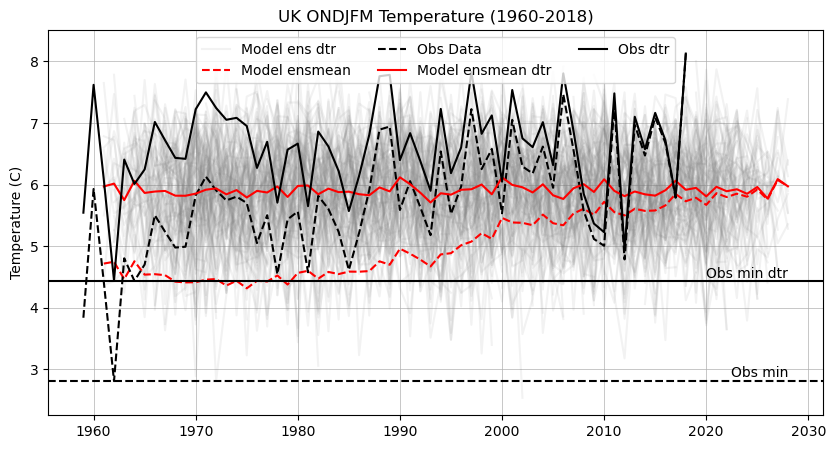

In [ ]:
# set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Calculate the model ensmean
model_ensmean = df_model_tas.groupby("effective_dec_year")["data_c"].mean()
model_ensmean_dt = df_model_tas.groupby("effective_dec_year")["data_c_dt"].mean()

# unqiue effective dec years
unique_years = df_model_tas["effective_dec_year"].unique()

# print the shape of the model ensmean
print(model_ensmean.shape)
print(unique_years.shape)

# loop over the unqiue members
for i, member in enumerate(df_model_tas["member"].unique()):
    # loop over the unique init years
    for j, init_year in enumerate(df_model_tas["init_year"].unique()):
        # subset the data
        df_model_tas_this = df_model_tas_wyear[
            (df_model_tas_wyear["member"] == member) & (df_model_tas_wyear["init_year"] == init_year)
        ]


        if i == 0 and j == 0:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c_dt"],
                color="grey",
                alpha=0.1,
                label="Model ens dtr",
            )
        else:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c_dt"],
                color="grey",
                alpha=0.1,
            )

# # plot the model ensmean not detrended
plt.plot(
    unique_years,
    model_ensmean,
    color="red",
    label="Model ensmean",
    linestyle="--",
)

# # plot the obs data not detrended
plt.plot(
    df_obs_tas_ondjfm.index.year,
    df_obs_tas_ondjfm["data_c"],
    color="black",
    label="Obs Data",
    linestyle="--",
)

# plot the model ensmean detrended
plt.plot(
    unique_years,
    model_ensmean_dt,
    color="red",
    label="Model ensmean dtr",
)

# plot the obs data detrended
plt.plot(
    df_obs_tas_ondjfm.index.year,
    df_obs_tas_ondjfm["data_c_dt"],
    color="black",
    label="Obs dtr",
)

# plot a solid horizontal line 
# for the minimum value of the detrended obs
plt.axhline(
    y=df_obs_tas_ondjfm["data_c_dt"].min(),
    color="black",
)

# plot a dashed horizontal line
# for the minimum value of the detrended obs
plt.axhline(
    y=df_obs_tas_ondjfm["data_c"].min(),
    color="black",
    linestyle="--",
)

# include titles for the horixzontak lines
plt.text(
    x=unique_years[-1],
    y=df_obs_tas_ondjfm["data_c_dt"].min(),
    s="Obs min dtr",
    color="black",
    verticalalignment="bottom",
    horizontalalignment="right",
)

plt.text(
    x=unique_years[-1],
    y=df_obs_tas_ondjfm["data_c"].min() + 0.25,
    s="Obs min",
    color="black",
    verticalalignment="top",
    horizontalalignment="right",
)

# Add labels and legend
# include horizontal anad vertical gridlines
ax.set_ylabel("Temperature (C)")

# Add labels and legend
ax.grid(which="both", linewidth=0.5)

# Set a title
ax.set_title("UK ONDJFM Temperature (1960-2018)")

# include the legend centred under the title
ax.legend(loc="upper center", ncol=3)

/tmp/ipykernel_2479716/1656562115.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model_ondjfm_wyear_all_members_mean = pd.concat([df_model_ondjfm_wyear_all_members_mean, df_this], ignore_index=True)


   centered_effective_dec_year member    data_c
0                       1965.5      1  3.999673
1                       1966.5      1  4.137307
2                       1967.5      1  4.563099
3                       1968.5      1  4.626115
4                       1969.5      1  4.197339


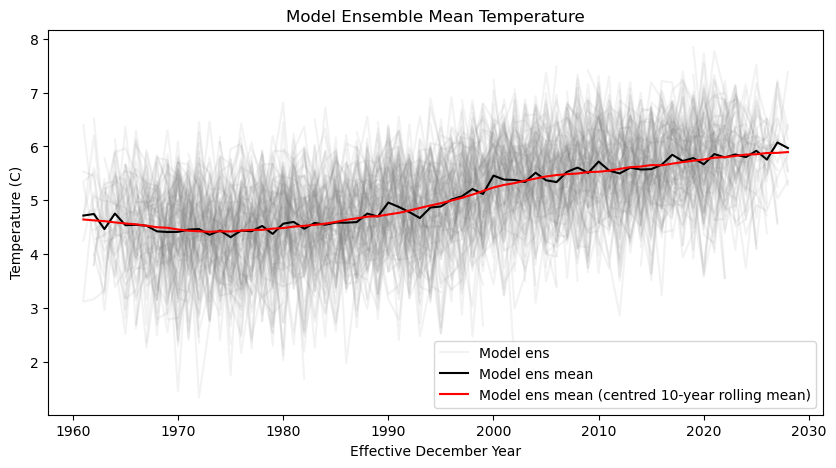

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Plot the data with no detrend
# # Set up the figure
# fig, ax = plt.subplots(figsize=(10, 5))

# # Set up the unique years
# model_years = df_model_ondjfm_wyear["effective_dec_year"].unique()

# # Calculate the ensemble mean
# model_ensmean = df_model_ondjfm_wyear.groupby("effective_dec_year")["data_c"].mean()

# # Calculate the model ensemble mean
# df_model_ondjfm_wyear_mean = df_model_ondjfm_wyear.groupby(["effective_dec_year", "member", "init_year"]).mean().reset_index()

# # Set up a new dataframe
# df_model_ondjfm_wyear_all_members_mean = pd.DataFrame(columns=["centered_effective_dec_year", "member", "data_c"])

# # Loop over the unique members
# for i, member in enumerate(df_model_ondjfm_wyear["member"].unique()):
#     # Loop over the unique init years
#     for j, init_year in enumerate(df_model_ondjfm_wyear["init_year"].unique()):
#         # Subset the data
#         df_model_tas_this = df_model_ondjfm_wyear_mean[
#             (df_model_ondjfm_wyear_mean["member"] == member) & (df_model_ondjfm_wyear_mean["init_year"] == init_year)
#         ]

#         if i == 0 and j == 0:
#             # Plot the data
#             plt.plot(
#                 df_model_tas_this["effective_dec_year"],
#                 df_model_tas_this["data_c"],
#                 color="grey",
#                 alpha=0.1,
#                 label="Model ens",
#             )
#         else:
#             # Plot the data
#             plt.plot(
#                 df_model_tas_this["effective_dec_year"],
#                 df_model_tas_this["data_c"],
#                 color="grey",
#                 alpha=0.1,
#             )

#         # Set up a new df this
#         df_this = pd.DataFrame(
#             {
#                 "centered_effective_dec_year": [df_model_tas_this["effective_dec_year"].mean()],
#                 "member": [member],
#                 "data_c": [df_model_tas_this["data_c"].mean()],
#             }
#         )

#         # Append to the new df
#         df_model_ondjfm_wyear_all_members_mean = pd.concat([df_model_ondjfm_wyear_all_members_mean, df_this], ignore_index=True)

# # Print the head of the new df
# print(df_model_ondjfm_wyear_all_members_mean.head())

# # round the centered_effective_dec_year to the nearest year
# df_model_ondjfm_wyear_all_members_mean["centered_effective_dec_year"] = np.round(df_model_ondjfm_wyear_all_members_mean["centered_effective_dec_year"])

# # Calculate the ensemble mean
# model_ensmean_init = df_model_ondjfm_wyear_all_members_mean.groupby("centered_effective_dec_year")["data_c"].mean()

# central_years = df_model_ondjfm_wyear_all_members_mean["centered_effective_dec_year"].unique()

# # plot the ensemble mean
# # plt.plot(
# #     central_years,
# #     model_ensmean_init,
# #     color="black",
# #     label="Model ens mean (centred)",
# #     linestyle="--",
# # )

# # Plot the ensemble mean
# plt.plot(
#     model_years,
#     model_ensmean,
#     color="black",
#     label="Model ens mean",
# )

# # Quantify a 10-year rolling mean of the model ensmean
# model_ensmean_rolling = model_ensmean.rolling(window=10, center=True, min_periods=1).mean()

# # Plot the ensemble mean
# plt.plot(
#     model_years,
#     model_ensmean_rolling,
#     color="red",
#     label="Model ens mean (centred 10-year rolling mean)",
# )

# # set the y label
# plt.ylabel("Temperature (C)")

# # set the x label
# plt.xlabel("Effective December Year")

# # set the title
# plt.title("Model Ensemble Mean Temperature")

# # Include a legend
# plt.legend()
# plt.show()

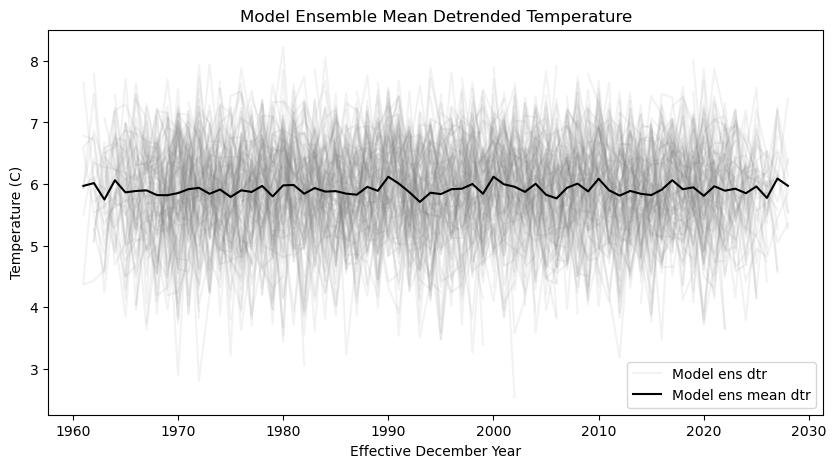

In [ ]:
# Now remove the red line from the ensemble and calculate the ensemble mean

model_ensmean_rolling.head()

# Set up the trend line
trend_line = model_ensmean_rolling

# get the final value
final_value = trend_line.iloc[-1]

# Set up a new column in df_model_ondjfm_wyear
df_model_ondjfm_wyear["data_c_dt"] = df_model_ondjfm_wyear["data_c"] - trend_line.loc[df_model_ondjfm_wyear["effective_dec_year"].values].values + final_value

# Take the mean again
df_model_ondjfm_wyear_mean = df_model_ondjfm_wyear.groupby(["effective_dec_year", "member", "init_year"]).mean().reset_index()


fig, ax = plt.subplots(figsize=(10, 5))

# loop over the unique members
for i, member in enumerate(df_model_ondjfm_wyear["member"].unique()):
    for j, init_year in enumerate(df_model_ondjfm_wyear["init_year"].unique()):
        # subset the data
        df_model_tas_this = df_model_ondjfm_wyear_mean[
            (df_model_ondjfm_wyear_mean["member"] == member) & (df_model_ondjfm_wyear_mean["init_year"] == init_year)
        ]


        if i == 0 and j == 0:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c_dt"],
                color="grey",
                alpha=0.1,
                label="Model ens dtr",
            )
        else:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c_dt"],
                color="grey",
                alpha=0.1,
            )

# Plot the ensemble mean
plt.plot(
    np.unique(df_model_ondjfm_wyear_mean["effective_dec_year"]),
    df_model_ondjfm_wyear_mean.groupby("effective_dec_year")["data_c_dt"].mean(),
    color="black",
    label="Model ens mean dtr",
)

# set the y label
plt.ylabel("Temperature (C)")

# set the x label
plt.xlabel("Effective December Year")

# set the title
plt.title("Model Ensemble Mean Detrended Temperature")

# Include a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import apply_detrend, apply_detrend_polynomial

In [ ]:
# # apply the detrend function to the data
# df_obs_tas, df_model_tas = apply_detrend(
#     obs_df=df_obs_tas,
#     model_df=df_model_ondjfm_wyear,
#     obs_val_name="data_c",
#     model_val_name="data_c",
#     obs_time_name="time",
#     model_time_name="effective_dec_year",
#     model_member_name="member",
#     model_lead_name="winter_year",
# )

In [ ]:
df_obs_tas.tail()

,time,data,data_c
21545,2018-12-27,280.410430,7.260430
21546,2018-12-28,280.654895,7.504895
21547,2018-12-29,281.870591,8.720591
21548,2018-12-30,282.060577,8.910577
21549,2018-12-31,282.126349,8.976349


In [ ]:
# set up a new time column as no. sec since 1960
df_obs_tas["time_sec"] = (df_obs_tas["time"] - datetime(1960, 1, 1)).dt.total_seconds()

In [ ]:
df_obs_tas, df_model_tas = apply_detrend_polynomial(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time_sec",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name="winter_year",
)

The shape of model df init years is (1062000, 3)
The shape of the coeffs array is (10, 4)


In [ ]:
df_obs_tas.head()

,time,data,data_c,time_sec,data_c_dt
0,1960-01-01,280.004414,6.854414,0.0,8.079088
1,1960-01-02,276.900436,3.750436,86400.0,4.974923
2,1960-01-03,278.757843,5.607843,172800.0,6.832144
3,1960-01-04,281.210861,8.060861,259200.0,9.284974
4,1960-01-05,278.524161,5.374161,345600.0,6.598088


In [ ]:
df_model_tas.head()

,init_year,member,lead,data,data_c,winter_year,effective_dec_year,data_c_dt
330,1960,1,331,283.344633,10.194633,1,1961,11.231771
331,1960,1,332,284.247110,11.097110,1,1961,12.134248
332,1960,1,333,284.948156,11.798156,1,1961,12.835294
333,1960,1,334,284.529038,11.379038,1,1961,12.416176
334,1960,1,335,284.921268,11.771268,1,1961,12.808406


In [ ]:
# create a new dataframe
# group by the winter year and member
# and take the mean
df_model_tas_mean = df_model_tas.groupby(["effective_dec_year", "member", "init_year"]).mean().reset_index()

In [ ]:
df_model_tas_mean.head()

,effective_dec_year,member,init_year,lead,data,data_c,winter_year,data_c_dt
0,1961,1,1960,420.5,278.461009,5.311009,1.0,6.348146
1,1961,2,1960,420.5,276.268232,3.118232,1.0,4.155370
2,1961,3,1960,420.5,278.498982,5.348982,1.0,6.386120
3,1961,4,1960,420.5,277.834329,4.684329,1.0,5.721467
4,1961,5,1960,420.5,277.846542,4.696542,1.0,5.733680


In [ ]:
# ensure that time is a datetime object in the obs data
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], format="%Y-%m-%d")

In [ ]:
# set time as the index
df_obs_tas.set_index("time", inplace=True)

# Assuming df_obs_tas is your DataFrame
# Shift back by 3 months using pd.DateOffset
df_obs_tas_ondjfm = df_obs_tas.shift(periods=-3, freq=pd.DateOffset(months=3)).resample("A").mean()

/tmp/ipykernel_1950787/3710817205.py:6: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_obs_tas_ondjfm = df_obs_tas.shift(periods=-3, freq=pd.DateOffset(months=3)).resample("A").mean()


In [ ]:
df_obs_tas_ondjfm.shape

(60, 4)

In [ ]:
# esnure that the time is a datetime object in the model data
df_model_tas_mean["effective_dec_year"] = pd.to_datetime(df_model_tas_mean["effective_dec_year"], format="%Y")

In [ ]:
# # ensure that the index of obs is just formated as the year
# df_obs_tas_ondjfm.index = df_obs_tas_ondjfm.index.year

In [ ]:
df_obs_tas_ondjfm.tail()

,data,data_c,time_sec,data_c_dt
time,,,,
2014-12-31,279.620865,6.470865,1.735560e+09,5.818621
2015-12-31,280.240061,7.090061,1.767139e+09,6.418261
2016-12-31,279.824490,6.674490,1.798718e+09,5.982921
2017-12-31,278.936009,5.786009,1.830254e+09,5.074444
2018-12-31,281.275890,8.125890,1.857902e+09,7.396558


(68,)
(68,)


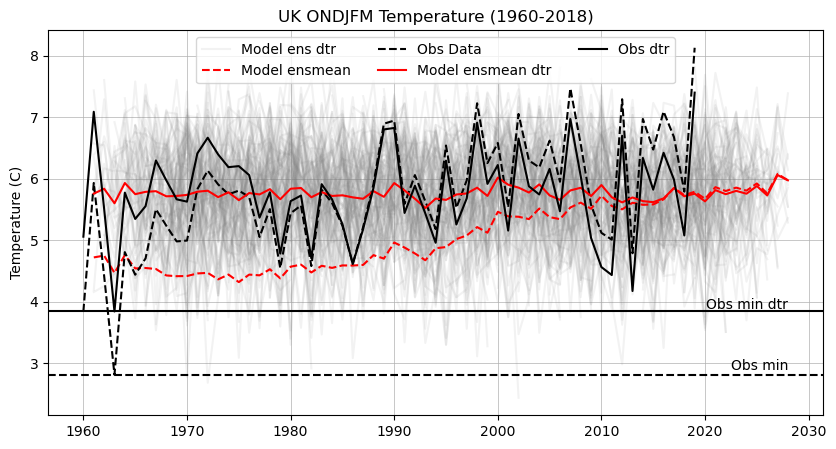

In [ ]:
# set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Calculate the model ensmean
model_ensmean = df_model_tas_mean.groupby("effective_dec_year")["data_c"].mean()
model_ensmean_dt = df_model_tas_mean.groupby("effective_dec_year")["data_c_dt"].mean()

# unqiue effective dec years
unique_years = df_model_tas_mean["effective_dec_year"].unique()

# print the shape of the model ensmean
print(model_ensmean.shape)
print(unique_years.shape)

# loop over the unqiue members
for i, member in enumerate(df_model_tas_mean["member"].unique()):
    # loop over the unique init years
    for j, init_year in enumerate(df_model_tas_mean["init_year"].unique()):
        # subset the data
        df_model_tas_this = df_model_tas_mean[
            (df_model_tas_mean["member"] == member) & (df_model_tas_mean["init_year"] == init_year)
        ]


        if i == 0 and j == 0:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c_dt"],
                color="grey",
                alpha=0.1,
                label="Model ens dtr",
            )
        else:
            # plot the data
            plt.plot(
                df_model_tas_this["effective_dec_year"],
                df_model_tas_this["data_c_dt"],
                color="grey",
                alpha=0.1,
            )

# # plot the model ensmean not detrended
plt.plot(
    unique_years,
    model_ensmean,
    color="red",
    label="Model ensmean",
    linestyle="--",
)

# # plot the obs data not detrended
plt.plot(
    df_obs_tas_ondjfm.index,
    df_obs_tas_ondjfm["data_c"],
    color="black",
    label="Obs Data",
    linestyle="--",
)

# plot the model ensmean detrended
plt.plot(
    unique_years,
    model_ensmean_dt,
    color="red",
    label="Model ensmean dtr",
)

# plot the obs data detrended
plt.plot(
    df_obs_tas_ondjfm.index,
    df_obs_tas_ondjfm["data_c_dt"],
    color="black",
    label="Obs dtr",
)

# plot a solid horizontal line 
# for the minimum value of the detrended obs
plt.axhline(
    y=df_obs_tas_ondjfm["data_c_dt"].min(),
    color="black",
)

# plot a dashed horizontal line
# for the minimum value of the detrended obs
plt.axhline(
    y=df_obs_tas_ondjfm["data_c"].min(),
    color="black",
    linestyle="--",
)

# include titles for the horixzontak lines
plt.text(
    x=unique_years[-1],
    y=df_obs_tas_ondjfm["data_c_dt"].min(),
    s="Obs min dtr",
    color="black",
    verticalalignment="bottom",
    horizontalalignment="right",
)

plt.text(
    x=unique_years[-1],
    y=df_obs_tas_ondjfm["data_c"].min() + 0.25,
    s="Obs min",
    color="black",
    verticalalignment="top",
    horizontalalignment="right",
)

# Add labels and legend
# include horizontal anad vertical gridlines
ax.set_ylabel("Temperature (C)")

# Add labels and legend
ax.grid(which="both", linewidth=0.5)

# Set a title
ax.set_title("UK ONDJFM Temperature (1960-2018)")

# include the legend centred under the title
ax.legend(loc="upper center", ncol=3)

Now we want to apply the detrend to the temperature time series, pivoting around the final point in the time series.

In [ ]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas['hdd'] = df_obs_tas['data_c'].apply(lambda x: max(0, hdd_base - x))
df_obs_tas['cdd'] = df_obs_tas['data_c'].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas['hdd'] = df_model_tas['data_c'].apply(lambda x: max(0, hdd_base - x))
df_model_tas['cdd'] = df_model_tas['data_c'].apply(lambda x: max(0, x - cdd_base))

In [ ]:
# Process the obs data
df_obs_tas['hdd_dt'] = df_obs_tas['data_c_dt'].apply(lambda x: max(0, hdd_base - x))
df_obs_tas['cdd_dt'] = df_obs_tas['data_c_dt'].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas['hdd_dt'] = df_model_tas['data_c_dt'].apply(lambda x: max(0, hdd_base - x))
df_model_tas['cdd_dt'] = df_model_tas['data_c_dt'].apply(lambda x: max(0, x - cdd_base))

In [ ]:
# Set up the path to the regression coeffs
regr_coeffs = "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand
df_obs_tas["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_obs_tas["hdd"]) +
    (cdd_coeff_uk * df_obs_tas["cdd"])
)

# Calculate the model demand
df_model_tas["UK_demand"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk *df_model_tas["hdd"]) +
    (cdd_coeff_uk *df_model_tas["cdd"])
)

# Calculate the obs demand detrended
df_obs_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_obs_tas["hdd_dt"]) +
    (cdd_coeff_uk * df_obs_tas["cdd_dt"])
)

# Calculate the model demand detrended
df_model_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017) + # demand year which the model is based on
    (hdd_coeff_uk * df_model_tas["hdd_dt"]) +
    (cdd_coeff_uk * df_model_tas["cdd_dt"])
)

In [ ]:
df_obs_tas.head()

,data,data_c,data_c_dt,hdd,cdd,hdd_dt,cdd_dt,UK_demand,UK_demand_dt
time,,,,,,,,,
1960-01-01,280.004414,6.854414,8.106242,8.645586,0,7.393758,0,41.519602,40.583725
1960-01-02,276.900436,3.750436,5.002264,11.749564,0,10.497736,0,43.840163,42.904285
1960-01-03,278.757843,5.607843,6.859671,9.892157,0,8.640329,0,42.451549,41.515671
1960-01-04,281.210861,8.060861,9.312689,7.439139,0,6.187311,0,40.617652,39.681774
1960-01-05,278.524161,5.374161,6.625989,10.125839,0,8.874011,0,42.626252,41.690374


In [ ]:
df_model_tas.head()

,init_year,member,lead,data,data_c,winter_year,effective_dec_year,data_c_dt,hdd,cdd,hdd_dt,cdd_dt,UK_demand,UK_demand_dt
330,1960,1,331,283.344633,10.194633,1,1961,11.446461,5.305367,0,4.053539,0,39.022425,38.086547
331,1960,1,332,284.247110,11.097110,1,1961,12.348938,4.402890,0,3.151062,0,38.347726,37.411848
332,1960,1,333,284.948156,11.798156,1,1961,13.049984,3.701844,0,2.450016,0,37.823617,36.887740
333,1960,1,334,284.529038,11.379038,1,1961,12.630866,4.120962,0,2.869134,0,38.136953,37.201076
334,1960,1,335,284.921268,11.771268,1,1961,13.023096,3.728732,0,2.476904,0,37.843719,36.907841


In [ ]:
# df_obs_tas.shape
# df_model_tas.shape

(10753, 9)

In [ ]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_distributions_fidelity, plot_cdfs, plot_qq

Calculating bootstrap statistics:   0%|          | 1/1000 [00:00<02:21,  7.08it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [02:21<00:00,  7.09it/s]


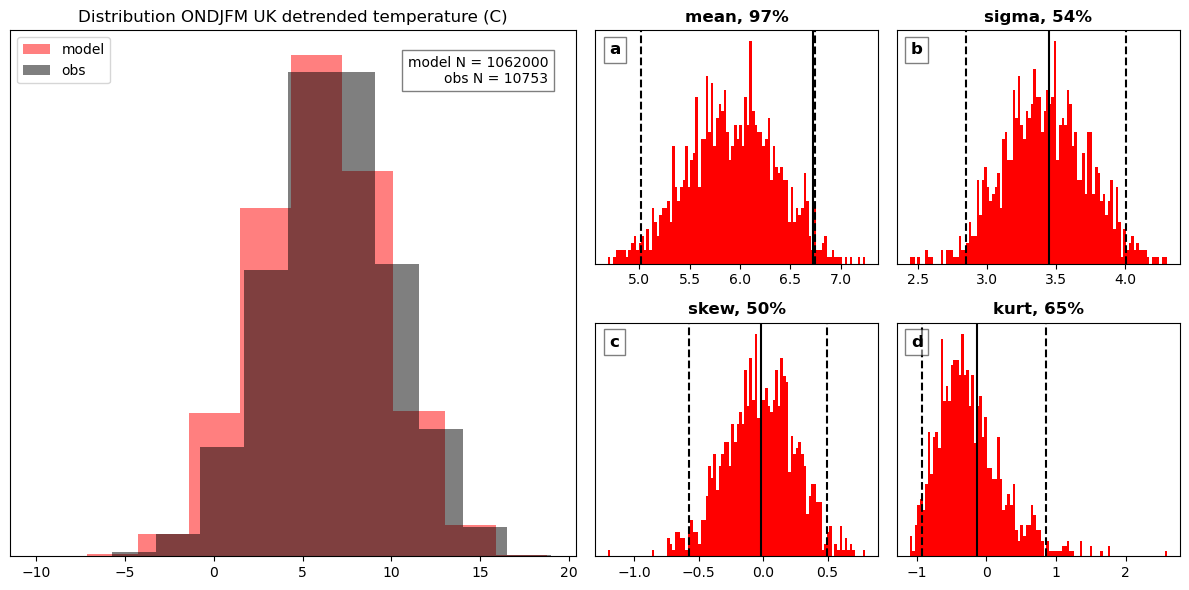

In [ ]:
plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="data_c_dt",
    model_val_name="data_c_dt",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK detrended temperature (C)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="UK_demand_ondjfm_distribution_fidelity_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Calculating bootstrap statistics:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [02:08<00:00,  7.79it/s]


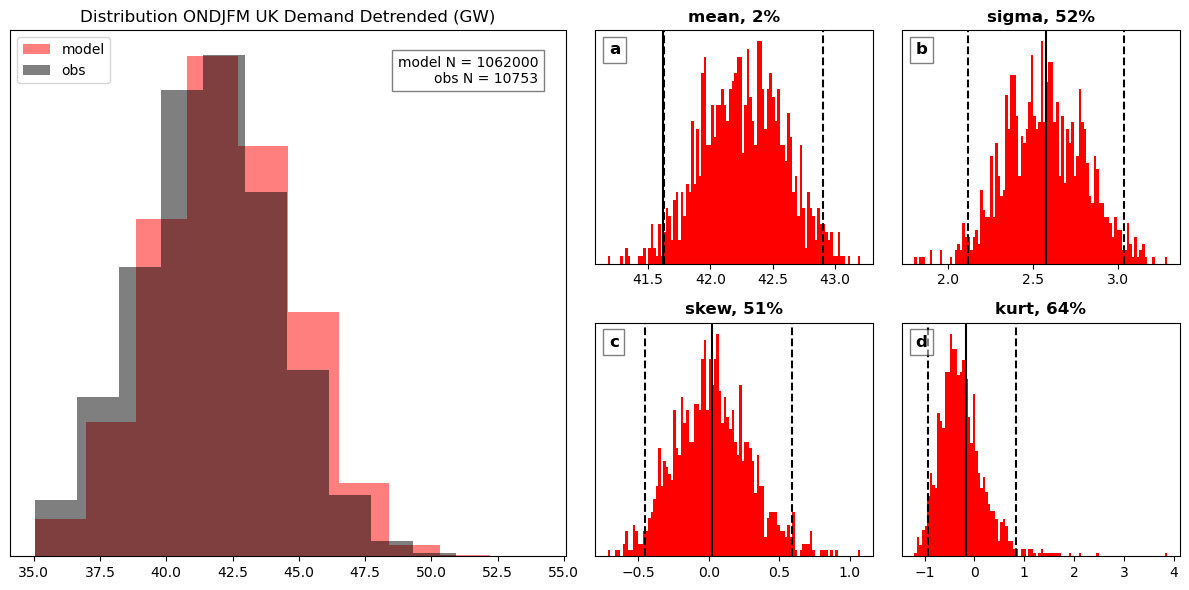

In [ ]:
# for detrended demand
plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="UK_demand_dt",
    model_val_name="UK_demand_dt",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK Demand Detrended (GW)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="UK_demand_dtr_ondjfm_distribution_fidelity_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Calculating bootstrap statistics:   2%|▏         | 2/100 [00:00<00:09,  9.91it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


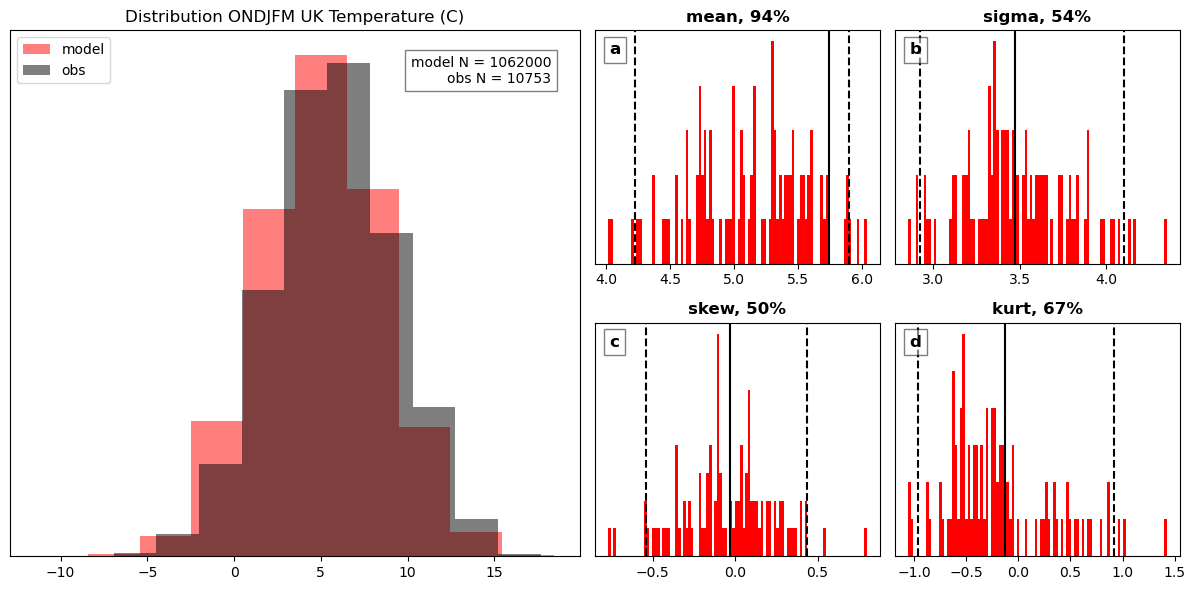

In [ ]:
# Do the same but for the temperature
plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK Temperature (C)",
    nboot=100,
    figsize=(12, 6),
    fname_prefix="UK_temp_ondjfm_distribution_fidelity_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

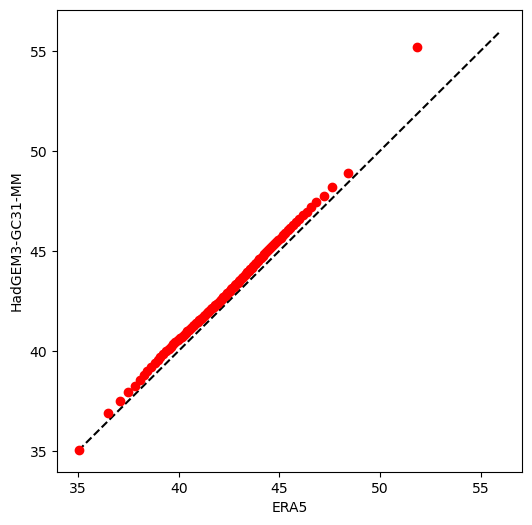

In [ ]:
plot_qq(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm,
    obs_val_name="UK_demand",
    model_val_name="UK_demand",
    save_prefix="UK_demand_ondjfm_qq_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

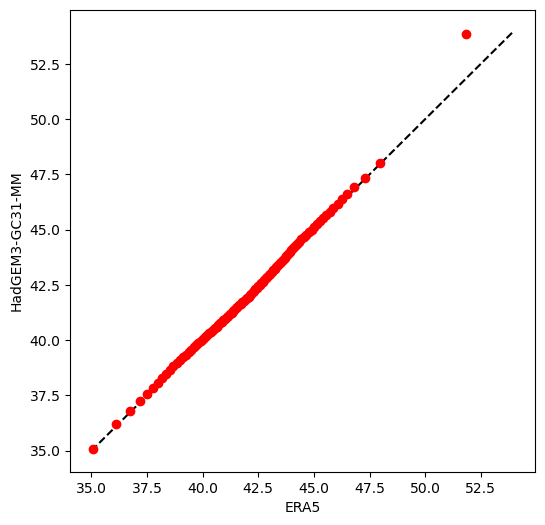

In [ ]:
plot_qq(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="UK_demand_dt",
    model_val_name="UK_demand_dt",
    save_prefix="UK_demand_dtr_ondjfm_qq_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

The ks stat is 0.07268210675845205
The ks p is 2.3935815847874098e-49
at alpha = 0.05, the critical value is 0.013181404756669374
at alpha = 0.01, the critical value is 0.01579830128924344
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution


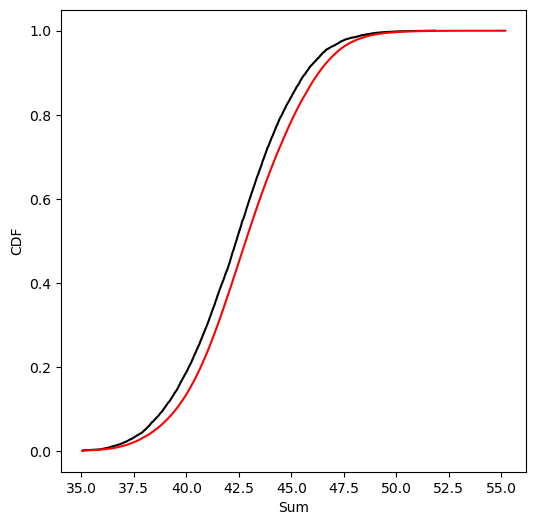

In [ ]:
plot_cdfs(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm,
    obs_val_name="UK_demand",
    model_val_name="UK_demand",
    save_prefix="UK_demand_ondjfm_cdf_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

The ks stat is 0.015397988963969766
The ks p is 0.012713419392520162
at alpha = 0.05, the critical value is 0.013181404756669374
at alpha = 0.01, the critical value is 0.01579830128924344
The null hypothesis is rejected at the 5% level
The two samples are not drawn from the same distribution
The null hypothesis is rejected at the 5% level
The two samples are not drawn from the same distribution


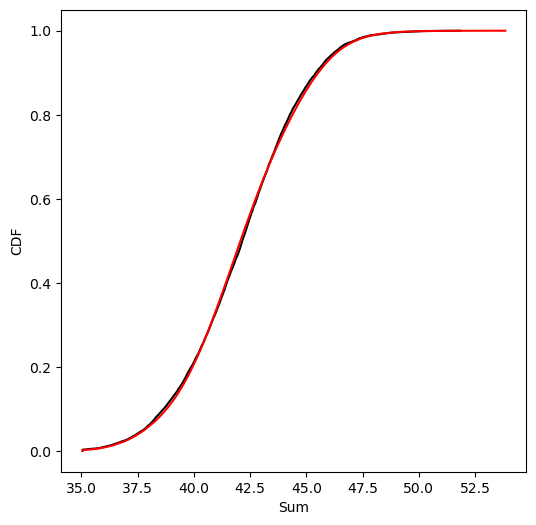

In [ ]:
# plot the cdfs for detrended demand
plot_cdfs(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="UK_demand_dt",
    model_val_name="UK_demand_dt",
    save_prefix="UK_demand_dtr_ondjfm_cdf_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [ ]:
df_obs_tas.head()

,time,data,data_c,hdd,cdd,UK_demand
0,1960-01-01,280.004414,6.854414,8.645586,0,41.519602
1,1960-01-02,276.900436,3.750436,11.749564,0,43.840163
2,1960-01-03,278.757843,5.607843,9.892157,0,42.451549
3,1960-01-04,281.210861,8.060861,7.439139,0,40.617652
4,1960-01-05,278.524161,5.374161,10.125839,0,42.626252


In [ ]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_monthly_boxplots

Text(0.5, 1.0, 'Boxplots of UK demand (GW) for United Kingdom ONDJFM 1960-2018 HadGEM3-GC31-MM dcppA-hindcast day')

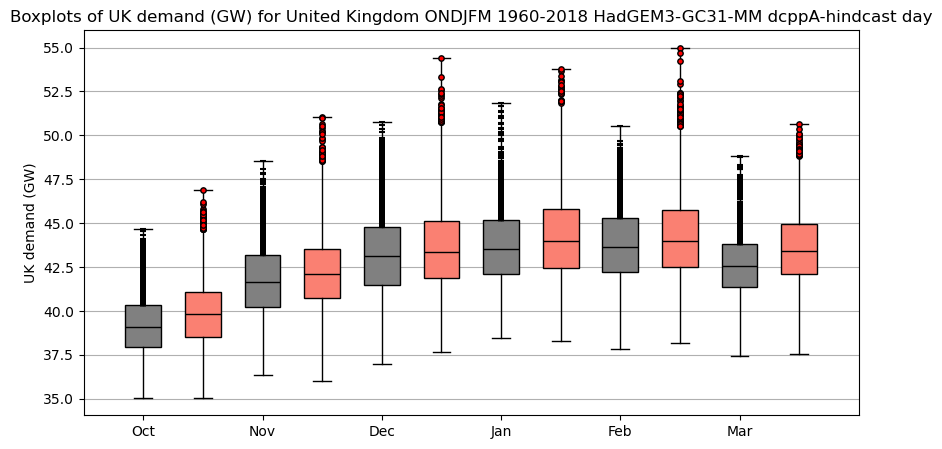

In [ ]:
# Set up the name
obs_val_name = "UK_demand"
model_val_name = "UK_demand"
variable = "UK demand (GW)"

# plot the boxplots for the different months
# set up the figure size
plt.figure(figsize=(10, 5))

# Set up the month names for the x-axis
month_names = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]

# Set up the ylabel
plt.ylabel(f"{variable}")

# Set up the lead_years
lead_years = np.arange(1, 11)

# set ip the months
months = [10, 11, 12, 1, 2, 3]

# assert that months is 10, 11, 12, 1, 2, 3
assert months == [10, 11, 12, 1, 2, 3], "Months not recognised"

# # if variable is tas, convert to C
# if variable == "tas":
#     df_obs_tas[obs_val_name] = df_obs_tas[obs_val_name] - 273.15
#     df_model_ondjfm[model_val_name] = df_model_ondjfm[model_val_name] - 273.15

# Loop over the months
for i, month in enumerate(months):
    # subset to the month
    obs_df_month = df_obs_tas[df_obs_tas["time"].dt.month == month]

    leads_this_month = []

    # find the leads to extract
    for j, ly in enumerate(lead_years):
        # set up the leads
        leads_this_month = np.arange(331 + (j * 360) + (i * 30), 331 + 30 + (j * 360) + (i * 30))


    # subset to the leads
    model_df_month = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads_this_month)]

    # Calculate the upper quartile (75th percentile)
    obs_lower_quartile = np.percentile(obs_df_month[obs_val_name], 25)
    obs_upper_quartile = np.percentile(obs_df_month[obs_val_name], 75)
    model_lower_quartile = np.percentile(model_df_month[model_val_name], 25)

    # calculate the obs min value for the month
    obs_min = np.min(obs_df_month[obs_val_name])
    obs_max = np.max(obs_df_month[obs_val_name])

    # Plot the observed data in black
    obs_box = plt.boxplot(
        obs_df_month[obs_val_name],
        positions=[i + 1],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True
    )

    # Set the face color for the observed data box
    for box in obs_box['boxes']:
        box.set(facecolor='grey')

    # Plot the model data in red
    model_box = plt.boxplot(
        model_df_month[model_val_name],
        positions=[i + 1.5],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True,
    )

    # Set the face color for the model data box
    for box in model_box['boxes']:
        box.set(facecolor='salmon')    

    # add scatter points for obs values beneath the lower quartile
    obs_below_lower_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] < obs_lower_quartile]
    obs_above_upper_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] > obs_upper_quartile]

    plt.scatter(
        [i + 1] * len(obs_above_upper_quartile),
        obs_above_upper_quartile,
        color="black",
        marker="_",
        s=15,
        zorder=10,
    )

    # # add scatter points for model values beneath the lower quartile
    # model_below_lower_quartile = model_df_month[model_val_name][model_df_month[model_val_name] < model_lower_quartile]
    # plt.scatter(
    #     [i + 1.5] * len(model_below_lower_quartile),
    #     model_below_lower_quartile,
    #     color="red",
    #     marker="_",
    #     s=20,
    # )

    # add red dots for the points which are lower than the obs min
    model_below_obs_min = model_df_month[model_val_name][model_df_month[model_val_name] < obs_min]
    model_above_obs_max = model_df_month[model_val_name][model_df_month[model_val_name] > obs_max]

    # plot the model data
    plt.scatter(
        [i + 1.5] * len(model_above_obs_max),
        model_above_obs_max,
        color="red",
        edgecolor="black",
        marker="o",
        s=15,
        zorder=10,
    )

# include gridlines
plt.grid(axis="y")

# set the xticks
plt.xticks(ticks=np.arange(1, 7), labels=month_names)

# Set up the season
season = "ONDJFM"
first_year = 1960
last_year = 2018
country = "United Kingdom"

# set the title
plt.title(f"Boxplots of {variable} for {country} {season} {first_year}-{last_year} HadGEM3-GC31-MM {experiment} {freq}")

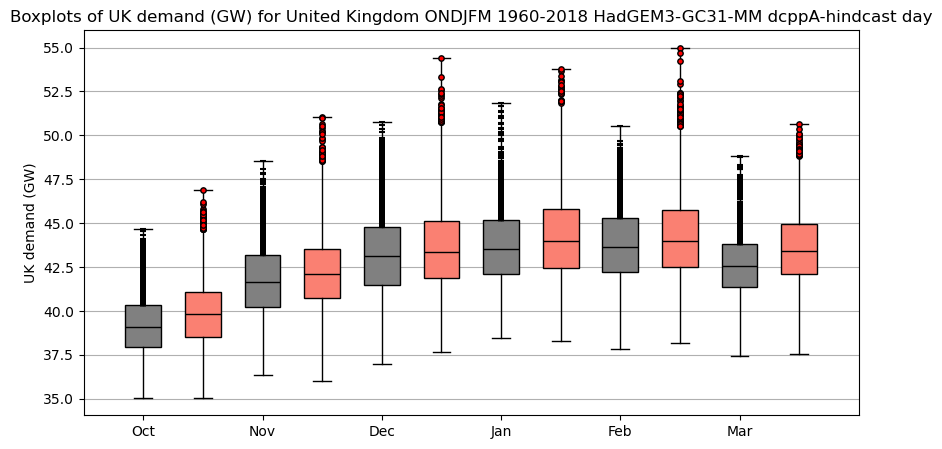

In [ ]:
# test the function for this
plot_monthly_boxplots(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm,
    obs_val_name="UK_demand",
    model_val_name="UK_demand",
    variable="UK demand (GW)",
    months=[10, 11, 12, 1, 2, 3],
    month_names=["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"],
    lead_years=np.arange(1, 11),
    season="ONDJFM",
    first_year=1960,
    last_year=2018,
    country="United Kingdom",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Works :)

Now we want to look at the no. days within the winter which exceed a specific threshold (e.g. the 92th percentile) and also the severity. First we should apply a simple mean bias correction to the model demand.

In [ ]:
df_obs_tas.columns

Index(['time', 'data', 'data_c', 'hdd', 'cdd', 'UK_demand'], dtype='object')

In [ ]:
# ensure that time is pd.datetime
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"])

# set as the index
df_obs_tas.set_index("time", inplace=True)

In [ ]:
df_obs_tas.head()

,data,data_c,data_c_dt,hdd,cdd,hdd_dt,cdd_dt,UK_demand,UK_demand_dt
time,,,,,,,,,
1960-01-01,280.004414,6.854414,8.869216,8.645586,0,6.630784,0,41.519602,40.013318
1960-01-02,276.900436,3.750436,5.765238,11.749564,0,9.734762,0,43.840163,42.333879
1960-01-03,278.757843,5.607843,7.622646,9.892157,0,7.877354,0,42.451549,40.945265
1960-01-04,281.210861,8.060861,10.075663,7.439139,0,5.424337,0,40.617652,39.111368
1960-01-05,278.524161,5.374161,7.388964,10.125839,0,8.111036,0,42.626252,41.119968


In [ ]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []
winter_mean_dnw = []

all_winters_92 = np.percentile(df_obs_tas["UK_demand"], 92)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs_tas.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["UK_demand"] > all_winters_92

    # # plot the data as a grey line
    # ax.plot(index_date, df["UK_demand"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["UK_demand"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["UK_demand"][mask] - all_winters_92).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # calculate the mean demand net wind for the winter
    winter_mean_dnw.append(df["UK_demand"].mean())

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["UK_demand"][mask])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
        "winter_mean_dnw": winter_mean_dnw,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [ ]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []
winter_mean_dnw = []

all_winters_92_dt = np.percentile(df_obs_tas["UK_demand_dt"], 92)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs_tas.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["UK_demand_dt"] > all_winters_92_dt

    # # plot the data as a grey line
    # ax.plot(index_date, df["UK_demand_dt"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["UK_demand_dt"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["UK_demand_dt"][mask] - all_winters_92_dt).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # calculate the mean demand net wind for the winter
    winter_mean_dnw.append(df["UK_demand_dt"].mean())

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["UK_demand_dt"][mask])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs_dt = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
        "winter_mean_dnw": winter_mean_dnw,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [ ]:
# print the row with the max value for no. exceedance days
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["no_exceedance_days"].idxmax()])

# print the row with the max value for severity index
print(df_exceedance_days_obs.loc[df_exceedance_days_obs["severity"].idxmax()])

severity              155.333629
no_exceedance_days     74.000000
winter_mean_dnw        44.543478
Name: 1962, dtype: float64
severity              155.333629
no_exceedance_days     74.000000
winter_mean_dnw        44.543478
Name: 1962, dtype: float64


In [ ]:
# same but for detrended data
# print the row with the max value for no. exceedance days
print(df_exceedance_days_obs_dt.loc[df_exceedance_days_obs_dt["no_exceedance_days"].idxmax()])

# print the row with the max value for severity index
print(df_exceedance_days_obs_dt.loc[df_exceedance_days_obs_dt["severity"].idxmax()])

severity              73.592228
no_exceedance_days    54.000000
winter_mean_dnw       43.246447
Name: 1978, dtype: float64
severity              77.747707
no_exceedance_days    27.000000
winter_mean_dnw       43.222666
Name: 1981, dtype: float64


In [ ]:
df_model_ondjfm.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719


In [ ]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

/tmp/ipykernel_1554906/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_1554906/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_1554906/1433218824.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
# Apply a mean bias correction to the model data
# Calculate the mean bias
mean_bias = df_obs_tas["UK_demand"].mean() - df_model_ondjfm_wyear["UK_demand"].mean()

# Apply the mean bias correction
df_model_ondjfm_wyear["UK_demand_bc"] = df_model_ondjfm_wyear["UK_demand"] + mean_bias

# # apply this corrected to the 05 and 95 percentiles
# df_model_ondjfm_wyear["UK_demand"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred_05"] + mean_bias
# df_model_ondjfm_wyear["wd_demand_net_wind_pred_95_bc"] = df_model_ondjfm_wyear["wd_demand_net_wind_pred_95"] + mean_bias

In [ ]:
# Extract the unique init years
init_years = df_model_ondjfm_wyear["init_year"].unique()
members = df_model_ondjfm_wyear["member"].unique()
winter_years = df_model_ondjfm_wyear["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days = np.zeros([len(init_years), len(members), len(winter_years)])

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_ondjfm_wyear[
                (df_model_ondjfm_wyear["init_year"] == i_year)
                & (df_model_ondjfm_wyear["member"] == member)
                & (df_model_ondjfm_wyear["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask = df_this["UK_demand_bc"] > all_winters_92

            # calculate the severity index
            model_severity_index[i, j, k] = (df_this["UK_demand_bc"][mask] - all_winters_92).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days[i, j, k] = mask.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity": [model_severity_index[i, j, k]],
                    "no_exceedance_days": [model_no_exceedance_days[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [ ]:
df_model_tas.head()

,init_year,member,lead,data,data_c,winter_year,effective_dec_year,data_c_dt,hdd_dt,cdd_dt,UK_demand_dt
330,1960,1,331,283.344633,10.194633,1,1961,12.209436,3.290564,0,37.516141
331,1960,1,332,284.247110,11.097110,1,1961,13.111912,2.388088,0,36.841442
332,1960,1,333,284.948156,11.798156,1,1961,13.812958,1.687042,0,36.317334
333,1960,1,334,284.529038,11.379038,1,1961,13.393841,2.106159,0,36.630670
334,1960,1,335,284.921268,11.771268,1,1961,13.786071,1.713929,0,36.337435


In [ ]:
# Extract the unique init years
init_years = df_model_tas["init_year"].unique()
members = df_model_tas["member"].unique()
winter_years = df_model_tas["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days = np.zeros([len(init_years), len(members), len(winter_years)])

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance_dt = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_tas[
                (df_model_tas["init_year"] == i_year)
                & (df_model_tas["member"] == member)
                & (df_model_tas["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask = df_this["UK_demand_dt"] > all_winters_92_dt

            # calculate the severity index
            model_severity_index[i, j, k] = (df_this["UK_demand_dt"][mask] - all_winters_92_dt).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days[i, j, k] = mask.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity": [model_severity_index[i, j, k]],
                    "no_exceedance_days": [model_no_exceedance_days[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance_dt = pd.concat([df_model_exceedance_dt, df_this_exceedance])

In [ ]:
# create a new column in df_model_exceedance
# effective dec_year
df_model_exceedance["effective_dec_year"] = df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]

In [ ]:
df_exceedance_days_obs_dt.head()

,severity,no_exceedance_days,winter_mean_dnw
1960,0.000000,0.0,40.705968
1961,13.718172,17.0,41.835238
1962,77.101101,50.0,43.037195
1963,3.070581,7.0,41.545992
1964,9.400250,15.0,41.821433


In [ ]:
df_model_exceedance_dt["effective_dec_year"] = df_model_exceedance_dt["init_year"] + df_model_exceedance_dt["winter_year"]

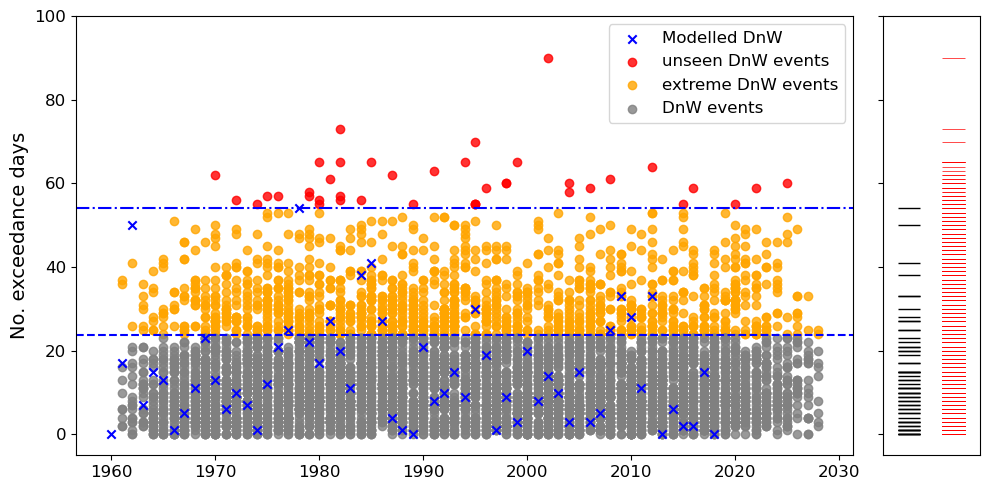

In [ ]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs_dt["no_exceedance_days"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs_dt["no_exceedance_days"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs_dt.index,
    df_exceedance_days_obs_dt["no_exceedance_days"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Plot a blue sahsed trend line for the obs
obs_trend = np.polyfit(df_exceedance_days_obs_dt.index, df_exceedance_days_obs_dt["no_exceedance_days"], 1)

# Separate model data by threshold
very_bad_events = df_model_exceedance_dt[
    df_model_exceedance_dt["no_exceedance_days"] > np.max(df_exceedance_days_obs_dt["no_exceedance_days"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance_dt[
    (df_model_exceedance_dt["no_exceedance_days"] > np.quantile(df_exceedance_days_obs_dt["no_exceedance_days"], 0.8)) &
    (df_model_exceedance_dt["no_exceedance_days"] < np.max(df_exceedance_days_obs_dt["no_exceedance_days"]))
]

# Model data below 80th percentile
events = df_model_exceedance_dt[
    df_model_exceedance_dt["no_exceedance_days"] < np.quantile(df_exceedance_days_obs_dt["no_exceedance_days"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["no_exceedance_days"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["no_exceedance_days"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["no_exceedance_days"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("No. exceedance days", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 100)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs_dt["no_exceedance_days"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance_dt["no_exceedance_days"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "no_exceedance_days_uk_demand_dtr_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


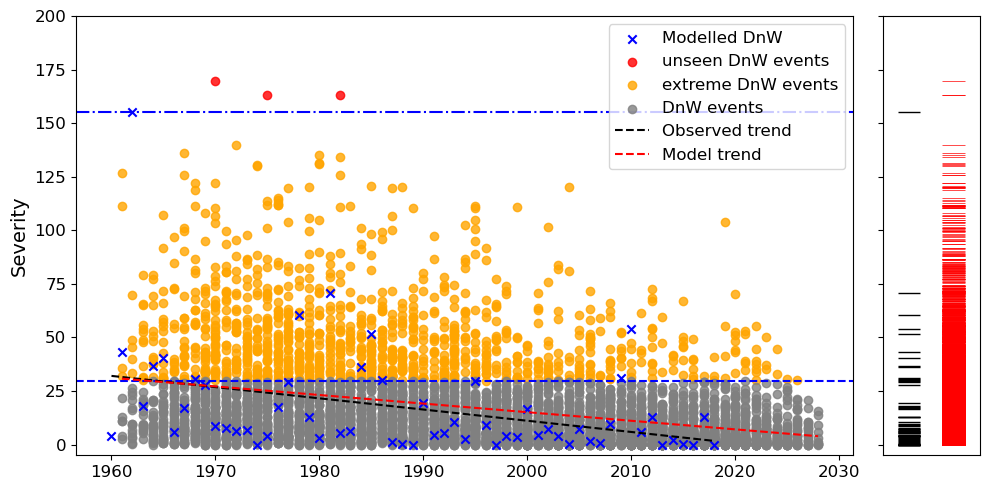

In [ ]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["severity"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["severity"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["severity"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["severity"] > np.max(df_exceedance_days_obs["severity"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["severity"] > np.quantile(df_exceedance_days_obs["severity"], 0.8)) &
    (df_model_exceedance["severity"] < np.max(df_exceedance_days_obs["severity"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["severity"] < np.quantile(df_exceedance_days_obs["severity"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["severity"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["severity"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["severity"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# Quantify the linear trend for th observations
obs_trend = np.polyfit(df_exceedance_days_obs.index, df_exceedance_days_obs["severity"], 1)

# Quantify the linear trend for the model data
model_trend = np.polyfit(df_model_exceedance["effective_dec_year"], df_model_exceedance["severity"], 1)

# plot the linear trend for the obs data as a dahsed black line
axs[0].plot(
    df_exceedance_days_obs.index,
    obs_trend[0] * df_exceedance_days_obs.index + obs_trend[1],
    color="k",
    linestyle="--",
    label="Observed trend",
)

# plot the linear trend for the model data as a dahsed red line
axs[0].plot(
    df_model_exceedance["effective_dec_year"],
    model_trend[0] * df_model_exceedance["effective_dec_year"] + model_trend[1],
    color="red",
    linestyle="--",
    label="Model trend",
)

# for the most extreme evnts
# # plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["severity"],
#     yerr=[
#         very_bad_events["severity"] - very_bad_events["severity_05"],  # lower errors
#         very_bad_events["severity_95"] - very_bad_events["severity"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("Severity", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 200)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["severity"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["severity"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "severity_uk_demand_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


Now perform the EVA for the demand data to explore the return period of known extremes

In [ ]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import empirical_return_level

In [ ]:
# import matplotlib
# import warnings
# from scipy.stats import genextreme as gev

# # silence the warnings
# warnings.filterwarnings("ignore")

# # Set up the probabilities
# probs = 1 / np.arange(1.1, 1000, 0.1) * 100

# years = np.arange(1.1, 1000, 0.1)

# # assuming ONDJFM
# # set up the lead years
# lead_years = np.arange(1, 11)

# # set up the months
# months = [10, 11, 12, 1, 2, 3]

# # Set up the number of samples
# n_samples = 1000

# # Quantify the return levels
# # For the number of exceedance days
# model_df_rl = empirical_return_level(
#     data=df_model_exceedance["no_exceedance_days"].values,
#     high_values_rare=True,
# )

# # print the head of the model_df_rl
# print(model_df_rl.head())

# # reverse the order of the rows
# model_df_rl_inverse = model_df_rl.iloc[::-1]

# # print the head of the model_df_rl_inverse
# print(model_df_rl_inverse.head())

# # Create an array to store the return levels
# model_rl = np.zeros([n_samples, len(model_df_rl)])
# obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# # Set up the model params
# model_params = []
# obs_params = []
# model_params_first = []

# model_params_first.append(
#     gev.fit(
#         df_model_exceedance["no_exceedance_days"],
#     )
# )

# # Loop over the no. samples
# for i in tqdm(range(n_samples)):
#     # Sample the model data
#     model_vals_this = np.random.choice(
#         df_model_exceedance["no_exceedance_days"],
#         size=len(model_df_rl["sorted"]),
#         replace=True,
#     )

#     # set up the obs vals this
#     obs_vals_this = np.random.choice(
#         df_exceedance_days_obs["no_exceedance_days"],
#         size=len(df_exceedance_days_obs["no_exceedance_days"]),
#         replace=True,
#     )

#     # Quantify the empirical return levels
#     model_df_rl_this = empirical_return_level(
#         data=model_vals_this,
#         high_values_rare=True,
#     )

#     # Quantify the return levels using the gev
#     model_params.append(
#         gev.fit(
#             model_vals_this,
#         )
#     )

#     # Set up the obs return levels
#     obs_params.append(
#         gev.fit(
#             obs_vals_this,
#         )
#     )

#     # Store the model return levels
#     model_rl[i, :] = model_df_rl_this["sorted"]


# levels_model = []
# levels_obs = []

# # loop over the num_samples
# for i in range(n_samples):
#     # Generate the ppf fit
#     levels_model.append(
#         np.array(gev.ppf(
#             1 - 1 / years,
#             *model_params[i],
#         ))
#     )

#     # Generate the ppf fit
#     levels_obs.append(
#         np.array(gev.ppf(
#             1 - 1 / years,
#             *obs_params[i],
#         ))
#     )

# # # Generate the ppf fit
# levels_model_first = np.array(gev.ppf(
#     1 - 1 / years,
#     *model_params_first[0],
# ))


In [ ]:
# probs

In [ ]:
# # convert probs to return levels in years
# return_years = 1 / (probs / 100)

In [ ]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import estimate_period

In [ ]:
# model_params = np.array(model_params)

In [ ]:
# # Set up the figure
# fig, ax = plt.subplots(figsize=(5, 5))

# # plot the observed return levels
# _ = ax.fill_between(
#     return_years,
#     np.quantile(levels_obs, 0.025, axis=0).T,
#     np.quantile(levels_obs, 0.975, axis=0).T,
#     color="gray",
#     alpha=0.5,
#     label="ERA5",
# )

# # plot the model return levels
# _ = ax.fill_between(
#     return_years,
#     np.quantile(levels_model, 0.025, axis=0).T,
#     np.quantile(levels_model, 0.975, axis=0).T,
#     color="red",
#     alpha=0.5,
#     label="HadGEM3-GC31-MM",
# )

# # Set up a logarithmic x-axis
# ax.set_xscale("log")

# # Limit to between 10 and 1000 years
# ax.set_xlim(10, 1000)

# # Set the xticks at 10, 20, 50, 100, 200, 500, 1000
# plt.xticks([10, 20, 50, 100, 200, 500, 1000], ["10", "20", "50", "100", "200", "500", "1000"])

# # Set the ylim
# ax.set_ylim(0, 120)

# # Set the ylabel
# ax.set_ylabel("No. exceedance days", fontsize=12)

# # set the xlabel
# ax.set_xlabel("Return period (years)", fontsize=12)

# # include the value of the worst obs event with a horizontal line
# ax.axhline(
#     np.max(df_exceedance_days_obs["no_exceedance_days"]),
#     color="blue",
#     linestyle="-",
# )

# # Include text on this line for the value
# ax.text(
#     11,
#     np.max(df_exceedance_days_obs["no_exceedance_days"]) + 2,
#     f"{round(np.max(df_exceedance_days_obs['no_exceedance_days']))} days",
#     color="blue",
#     fontsize=12,
# )

# # Quantify the return level for the worst obs event
# model_est_worst_obs = estimate_period(
#     return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
#     loc=model_params_first[0][1],
#     scale=model_params_first[0][2],
#     shape=model_params_first[0][0],
# )

# # Same but for the 2.5th percentile
# model_est_worst_obs_025 = estimate_period(
#     return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
#     loc=np.percentile(model_params[:, 1], 2.5),
#     scale=np.percentile(model_params[:, 2], 2.5),
#     shape=np.percentile(model_params[:, 0], 2.5),
# )

# # Same but for the 97.5th percentile
# model_est_worst_obs_975 = estimate_period(
#     return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
#     loc=np.percentile(model_params[:, 1], 97.5),
#     scale=np.percentile(model_params[:, 2], 97.5),
#     shape=np.percentile(model_params[:, 0], 97.5),
# )

# # print these values
# print(f"Model estimate for worst observed event: {model_est_worst_obs}")
# print(f"Model estimate for worst observed event 2.5th percentile: {model_est_worst_obs_025}")
# print(f"Model estimate for worst observed event 97.5th percentile: {model_est_worst_obs_975}")

# # process into estiates
# worst_event = 1 - (model_est_worst_obs / 100)
# worst_event_025 = 1 - (model_est_worst_obs_025 / 100)
# worst_event_975 = 1 - (model_est_worst_obs_975 / 100)

# # Calculate the return period
# rp_worst_event = 1 / worst_event
# rp_worst_event_025 = 1 / worst_event_025
# rp_worst_event_975 = 1 / worst_event_975

# # print these values
# print(f"Return period for worst observed event: {rp_worst_event}")
# print(f"Return period for worst observed event 2.5th percentile: {rp_worst_event_025}")
# print(f"Return period for worst observed event 97.5th percentile: {rp_worst_event_975}")

# central_95 = abs(rp_worst_event_975 - rp_worst_event_025) / 2

# # include a textbox in the top right with the return period of the worst observed event
# ax.text(
#     0.95,
#     0.02,
#     f"1962 RP: {round(rp_worst_event)} +/- {round(central_95)} years",
#     horizontalalignment="right",
#     verticalalignment="bottom",
#     transform=ax.transAxes,
#     fontsize=10,
#     # bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
# )

# # include a legend in the top left
# ax.legend(fontsize=10, loc='upper left')

In [ ]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_rp_extremes

In [ ]:
# if there is no column named "index"
if "index" not in df_exceedance_days_obs.columns:
    # reset the index
    df_exceedance_days_obs.reset_index(inplace=True)

In [ ]:
# # force "index" to be datetime
# df_exceedance_days_obs["index"] = pd.to_datetime(df_exceedance_days_obs["index"])

# # force model_df_rl to be datetime
# df_model_exceedance["effective_dec_year"] = pd.to_datetime(df_model_exceedance["effective_dec_year"])

In [ ]:
df_exceedance_days_obs.tail()

,index,severity,no_exceedance_days,winter_mean_dnw
54,2014,2.018469,4.0,41.806991
55,2015,0.234348,1.0,41.327466
56,2016,0.000000,0.0,41.654114
57,2017,12.741595,14.0,42.318351
58,2018,0.000000,0.0,40.569036


In [ ]:
df_model_exceedance.head()

,init_year,member,winter_year,severity,no_exceedance_days,effective_dec_year
0,1960,1,1,10.973360,7.0,1961
0,1960,1,2,39.914811,30.0,1962
0,1960,1,3,52.447130,35.0,1963
0,1960,1,4,8.411252,15.0,1964
0,1960,1,5,18.366987,25.0,1965


In [ ]:
df_exceedance_days_obs_dt.head()

,index,severity,no_exceedance_days,winter_mean_dnw
0,1960,0.000000,0.0,40.705968
1,1961,13.718172,17.0,41.835238
2,1962,77.101101,50.0,43.037195
3,1963,3.070581,7.0,41.545992
4,1964,9.400250,15.0,41.821433


In [ ]:
# if there is no column named "index"
if "index" not in df_exceedance_days_obs.columns:
    # reset the index
    df_exceedance_days_obs.reset_index(inplace=True)

In [ ]:
# reset the index of the detrendered data
df_exceedance_days_obs_dt.reset_index(inplace=True)

In [ ]:
# format the int column containing 1960, 1961 etc
# as datetime in years
df_exceedance_days_obs["index_dt"] = pd.to_datetime(df_exceedance_days_obs["index"], format="%Y")

In [ ]:
df_exceedance_days_obs_dt["index_dt"] = pd.to_datetime(df_exceedance_days_obs_dt["index"], format="%Y")

In [ ]:
# do the same for the model data
df_model_exceedance["effective_dec_year_dt"] = pd.to_datetime(df_model_exceedance["effective_dec_year"], format="%Y")

In [ ]:
df_model_exceedance_dt["effective_dec_year_dt"] = pd.to_datetime(df_model_exceedance_dt["effective_dec_year"], format="%Y")

   index    severity  no_exceedance_days  winter_mean_dnw   index_dt
0   1960    3.791915                 8.0        42.212252 1960-01-01
1   1961   43.280334                34.0        43.339972 1961-01-01
2   1962  155.333629                74.0        44.543478 1962-01-01
3   1963   17.898446                21.0        43.052275 1963-01-01
4   1964   36.459321                28.0        43.327717 1964-01-01
    index   severity  no_exceedance_days  winter_mean_dnw   index_dt
26   1986  30.014194                22.0        42.746605 1986-01-01
27   1987   1.152636                 4.0        42.207279 1987-01-01
28   1988   0.459833                 1.0        41.492320 1988-01-01
29   1989   0.000000                 0.0        41.454067 1989-01-01
30   1990  19.174646                18.0        42.466861 1990-01-01
   init_year  member  winter_year   severity  no_exceedance_days  \
0       1960       1            1  10.973360                 7.0   
0       1960       1            2  3

  1%|▏         | 14/1000 [00:01<01:34, 10.39it/s]

100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]


Model estimate for obs 99th %tile event: 98.16752454392187
Model estimate for obs 99th %tile event 2.5th percentile: 98.02362117314715
Model estimate for obs 99th %tile event 97.5th percentile: 98.32086376804853
Return period for obs 99th %tile event: 54.57099011520748
Return period for obs 99th %tile event 2.5th percentile: 50.59758718384876
Return period for obs 99th %tile event 97.5th percentile: 59.554429293554804
CPU times: user 1min 36s, sys: 187 ms, total: 1min 36s
Wall time: 1min 37s


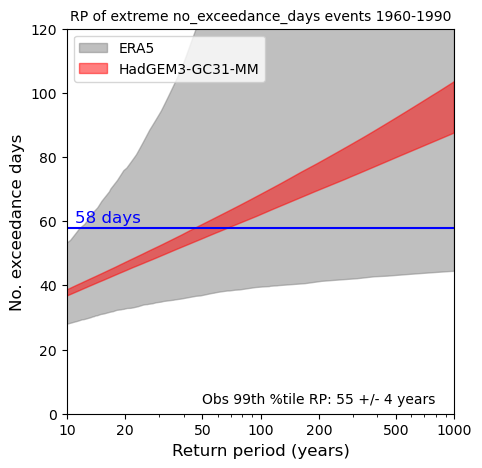

In [ ]:
%%time

# Now test the function which does the same
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days",
    model_val_name="no_exceedance_days",
    obs_time_name="index_dt",
    model_time_name="effective_dec_year_dt",
    years_period=(1960, 1990), # first half
)

   index   severity  no_exceedance_days  winter_mean_dnw   index_dt
0   1960   0.000000                 0.0        40.705968 1960-01-01
1   1961  13.718172                17.0        41.835238 1961-01-01
2   1962  77.101101                50.0        43.037195 1962-01-01
3   1963   3.070581                 7.0        41.545992 1963-01-01
4   1964   9.400250                15.0        41.821433 1964-01-01
    index   severity  no_exceedance_days  winter_mean_dnw   index_dt
54   2014   3.227099                 6.0        41.806991 2014-01-01
55   2015   0.533206                 2.0        41.327466 2015-01-01
56   2016   0.160554                 2.0        41.654114 2016-01-01
57   2017  16.673129                15.0        42.318351 2017-01-01
58   2018   0.000000                 0.0        40.569036 2018-01-01
   init_year  member  winter_year   severity  no_exceedance_days  \
0       1960       1            1   6.479586                 6.0   
0       1960       1            2  23.9460

100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s]


Model estimate for obs 99.9th %tile event: 98.28427724233211
Model estimate for obs 99.9th %tile event 2.5th percentile: 98.19486259500475
Model estimate for obs 99.9th %tile event 97.5th percentile: 98.40804059856944
Return period for obs 99.9th %tile event: 58.28447489728799
Return period for obs 99.9th %tile event 2.5th percentile: 55.397444938693276
Return period for obs 99.9th %tile event 97.5th percentile: 62.81567225278408
CPU times: user 2min 9s, sys: 298 ms, total: 2min 9s
Wall time: 2min 10s


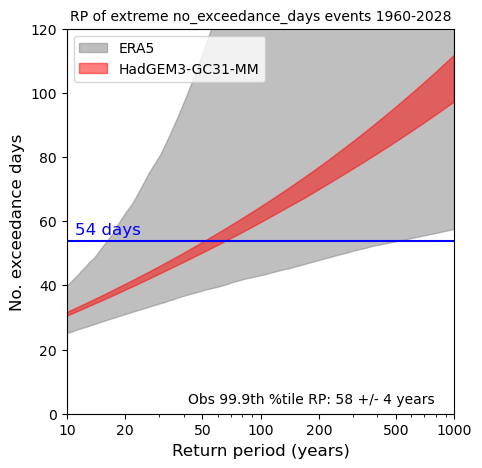

In [ ]:
%%time

# Now test the function which does the same
# reurn period of detrended demand extremes
plot_rp_extremes(
    obs_df=df_exceedance_days_obs_dt,
    model_df=df_model_exceedance_dt,
    obs_val_name="no_exceedance_days",
    model_val_name="no_exceedance_days",
    obs_time_name="index_dt",
    model_time_name="effective_dec_year_dt",
    percentile=99.9,
    # years_period=(1960, 1990), # first half
)

In [ ]:
df_exceedance_days_obs.head()

,index,severity,no_exceedance_days,winter_mean_dnw,index_dt
0,1960,3.791915,8.0,42.212252,1960-01-01
1,1961,43.280334,34.0,43.339972,1961-01-01
2,1962,155.333629,74.0,44.543478,1962-01-01
3,1963,17.898446,21.0,43.052275,1963-01-01
4,1964,36.459321,28.0,43.327717,1964-01-01


    index   severity  no_exceedance_days  winter_mean_dnw   index_dt
30   1990  19.174646                18.0        42.466861 1990-01-01
31   1991   4.332442                 6.0        42.118537 1991-01-01
32   1992   5.317888                 9.0        42.433663 1992-01-01
33   1993  10.367765                10.0        42.772687 1993-01-01
34   1994   2.592730                 5.0        41.757103 1994-01-01
    index   severity  no_exceedance_days  winter_mean_dnw   index_dt
54   2014   2.018469                 4.0        41.806991 2014-01-01
55   2015   0.234348                 1.0        41.327466 2015-01-01
56   2016   0.000000                 0.0        41.654114 2016-01-01
57   2017  12.741595                14.0        42.318351 2017-01-01
58   2018   0.000000                 0.0        40.569036 2018-01-01
   init_year  member  winter_year   severity  no_exceedance_days  \
0       1980       1           10  10.281965                 7.0   
0       1980       2           10  1

  0%|          | 3/1000 [00:00<01:35, 10.41it/s]

100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]


Model estimate for obs 99th %tile event: 98.62822676052286
Model estimate for obs 99th %tile event 2.5th percentile: 98.45189492394758
Model estimate for obs 99th %tile event 97.5th percentile: 98.80653412067261
Return period for obs 99th %tile event: 72.89834582143904
Return period for obs 99th %tile event 2.5th percentile: 64.59509858012632
Return period for obs 99th %tile event 97.5th percentile: 83.7895760005786
CPU times: user 1min 42s, sys: 180 ms, total: 1min 42s
Wall time: 1min 43s


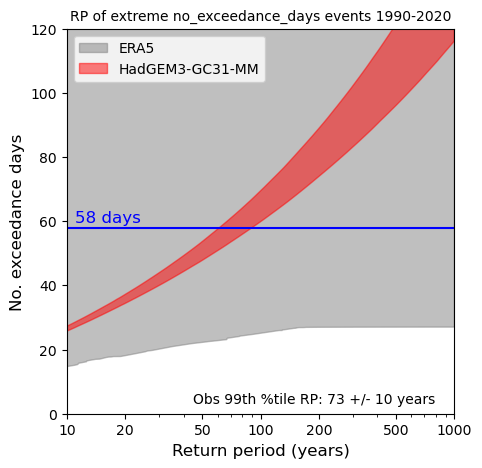

In [ ]:
%%time

# Now test the function which does the same
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days",
    model_val_name="no_exceedance_days",
    obs_time_name="index_dt",
    model_time_name="effective_dec_year_dt",
    years_period=(1990, 2020), # second half
)#

In [ ]:
# calculate the 95th percentile of the obs
obs_95 = np.percentile(df_exceedance_days_obs["no_exceedance_days"], 98)

obs_95

np.float64(44.71999999999997)

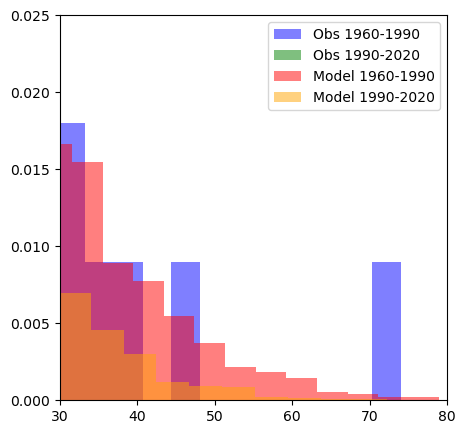

In [ ]:
# subset the model df to between 1960 and 1990
df_model_exceedance_1960_1990 = df_model_exceedance[
    (df_model_exceedance["effective_dec_year_dt"] >= "1960")
    & (df_model_exceedance["effective_dec_year_dt"] < "1990")
]

# for the obs
df_exceedance_days_obs_1960_1990 = df_exceedance_days_obs[
    (df_exceedance_days_obs["index_dt"] >= "1960")
    & (df_exceedance_days_obs["index_dt"] < "1990")
]

# and for the second half
df_model_exceedance_1990_2020 = df_model_exceedance[
    (df_model_exceedance["effective_dec_year_dt"] >= "1990")
    & (df_model_exceedance["effective_dec_year_dt"] < "2020")
]

# for the obs
df_exceedance_days_obs_1990_2020 = df_exceedance_days_obs[
    (df_exceedance_days_obs["index_dt"] >= "1990")
    & (df_exceedance_days_obs["index_dt"] < "2020")
]

# now plot histograms of the no. exceedance days
# for the first half
fig, ax = plt.subplots(figsize=(5, 5))

# plot the histogram for the obs (1960-1990) as a density function
ax.hist(
    df_exceedance_days_obs_1960_1990["no_exceedance_days"],
    bins=20,
    color="blue",
    alpha=0.5,
    label="Obs 1960-1990",
    density=True,
)

# plot the histogram for the obs (1990-2020) as a density function
ax.hist(
    df_exceedance_days_obs_1990_2020["no_exceedance_days"],
    bins=20,
    color="green",
    alpha=0.5,
    label="Obs 1990-2020",
    density=True,
)

# plot the histogram for the model (1960-1990) as a density function
ax.hist(
    df_model_exceedance_1960_1990["no_exceedance_days"],
    bins=20,
    color="red",
    alpha=0.5,
    label="Model 1960-1990",
    density=True,
)

# plot the histogram for the model (1990-2020) as a density function
ax.hist(
    df_model_exceedance_1990_2020["no_exceedance_days"],
    bins=20,
    color="orange",
    alpha=0.5,
    label="Model 1990-2020",
    density=True,
)

# set the x limit
ax.set_xlim(30, 80)

# set the ylimit
ax.set_ylim(0, 0.025)

# include the legend
ax.legend()

Now repeat this for the first 30 years of the period < 1990.

In [ ]:
# set up df model exceedance for the first 30 years
df_model_exceedance_first = df_model_exceedance[df_model_exceedance["effective_dec_year"] < 1990]
df_model_exceedance_last = df_model_exceedance[df_model_exceedance["effective_dec_year"] >= 1990]

In [ ]:
df_model_exceedance_first.tail()

,init_year,member,winter_year,severity,no_exceedance_days,effective_dec_year
0,1988,6,1,0.000000,0.0,1989
0,1988,7,1,13.382226,8.0,1989
0,1988,8,1,0.755726,3.0,1989
0,1988,9,1,2.200040,5.0,1989
0,1988,10,1,41.553451,29.0,1989


In [ ]:
import matplotlib
import warnings
from scipy.stats import genextreme as gev

# silence the warnings
warnings.filterwarnings("ignore")

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# Quantify the return levels
# For the number of exceedance days
model_df_rl = empirical_return_level(
    data=df_model_exceedance_first["no_exceedance_days"].values,
    high_values_rare=True,
)

# print the head of the model_df_rl
print(model_df_rl.head())

# reverse the order of the rows
model_df_rl_inverse = model_df_rl.iloc[::-1]

# print the head of the model_df_rl_inverse
print(model_df_rl_inverse.head())

# Create an array to store the return levels
model_rl = np.zeros([n_samples, len(model_df_rl)])
obs_rl = np.zeros([n_samples, len(df_exceedance_days_obs)])

# Set up the model params
model_params = []
obs_params = []
model_params_first = []

model_params_first.append(
    gev.fit(
        df_model_exceedance_first["no_exceedance_days"],
    )
)

# Loop over the no. samples
for i in tqdm(range(n_samples)):
    # Sample the model data
    model_vals_this = np.random.choice(
        df_model_exceedance_first["no_exceedance_days"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # set up the obs vals this
    obs_vals_this = np.random.choice(
        df_exceedance_days_obs["no_exceedance_days"],
        size=len(df_exceedance_days_obs["no_exceedance_days"]),
        replace=True,
    )

    # Quantify the empirical return levels
    model_df_rl_this = empirical_return_level(
        data=model_vals_this,
        high_values_rare=True,
    )

    # Quantify the return levels using the gev
    model_params.append(
        gev.fit(
            model_vals_this,
        )
    )

    # Set up the obs return levels
    obs_params.append(
        gev.fit(
            obs_vals_this,
        )
    )

    # Store the model return levels
    model_rl[i, :] = model_df_rl_this["sorted"]


levels_model = []
levels_obs = []

# loop over the num_samples
for i in range(n_samples):
    # Generate the ppf fit
    levels_model.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *model_params[i],
        ))
    )

    # Generate the ppf fit
    levels_obs.append(
        np.array(gev.ppf(
            1 - 1 / years,
            *obs_params[i],
        ))
    )

# # Generate the ppf fit
levels_model_first = np.array(gev.ppf(
    1 - 1 / years,
    *model_params_first[0],
))


      sorted  rank_sp  exceedance    period  probability
2449     0.0   2450.0    0.999592  1.000408    99.959200
2448     0.0   2449.0    0.999184  1.000817    99.918401
2447     0.0   2448.0    0.998776  1.001225    99.877601
2446     0.0   2447.0    0.998368  1.001635    99.836801
2445     0.0   2446.0    0.997960  1.002044    99.796002
   sorted  rank_sp  exceedance  period  probability
0    79.0     12.5      0.0051  196.08     0.509996
1    78.0     12.5      0.0051  196.08     0.509996
2    75.0     12.5      0.0051  196.08     0.509996
3    73.0     12.5      0.0051  196.08     0.509996
4    70.0     12.5      0.0051  196.08     0.509996


  0%|          | 1/1000 [00:00<01:50,  9.08it/s]

100%|██████████| 1000/1000 [01:32<00:00, 10.78it/s]


In [ ]:
model_params

[(np.float64(-0.7300596453470746),
  np.float64(5.785947812555387),
  np.float64(7.224164364270119)),
 (np.float64(-0.762931153292356),
  np.float64(5.603822418461611),
  np.float64(7.113325389530527)),
 (np.float64(-0.7390169660117382),
  np.float64(5.64174703692148),
  np.float64(7.096166962174721)),
 (np.float64(-0.7460930634242413),
  np.float64(5.682081013314395),
  np.float64(7.166745378519726)),
 (np.float64(-0.7245678906433712),
  np.float64(5.8117390693801365),
  np.float64(7.2151989393294205)),
 (np.float64(-0.6968907861563425),
  np.float64(6.0896179201570835),
  np.float64(7.473615000200464)),
 (np.float64(-0.7422291470235984),
  np.float64(5.8052617616405655),
  np.float64(7.251607237020906)),
 (np.float64(-0.700147114972427),
  np.float64(6.1380454183099165),
  np.float64(7.594710266618205)),
 (np.float64(-0.7227154536330871),
  np.float64(5.800057176897138),
  np.float64(7.1162815631080925)),
 (np.float64(-0.7155398393170482),
  np.float64(6.083710460273155),
  np.float6

Model estimate for worst observed event: 94.18489900251144
Model estimate for worst observed event 2.5th percentile: 93.9425823855645
Model estimate for worst observed event 97.5th percentile: 94.38025950960693
Return period for worst observed event: 17.19660587893286
Return period for worst observed event 2.5th percentile: 16.508685113882365
Return period for worst observed event 97.5th percentile: 17.794415982543995


Text(0.5, 1.0, '1961-1989')

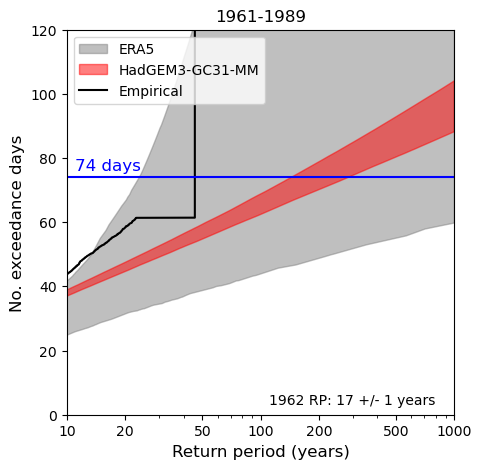

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(5, 5))

# convert probs to return levels in years
return_years = 1 / (probs / 100)

# plot the observed return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_obs, 0.025, axis=0).T,
    np.quantile(levels_obs, 0.975, axis=0).T,
    color="gray",
    alpha=0.5,
    label="ERA5",
)

# plot the model return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_model, 0.025, axis=0).T,
    np.quantile(levels_model, 0.975, axis=0).T,
    color="red",
    alpha=0.5,
    label="HadGEM3-GC31-MM",
)

# Set up a logarithmic x-axis
ax.set_xscale("log")

# Limit to between 10 and 1000 years
ax.set_xlim(10, 1000)

# Set the xticks at 10, 20, 50, 100, 200, 500, 1000
plt.xticks([10, 20, 50, 100, 200, 500, 1000], ["10", "20", "50", "100", "200", "500", "1000"])

# Set the ylim
ax.set_ylim(0, 120)

# Set the ylabel
ax.set_ylabel("No. exceedance days", fontsize=12)

# set the xlabel
ax.set_xlabel("Return period (years)", fontsize=12)

# plot the empirical return levels
_ = ax.plot(
    1 / (model_df_rl["probability"] / 100),
    model_df_rl["sorted"],
    color="black",
    label="Empirical",
)


# include the value of the worst obs event with a horizontal line
ax.axhline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="blue",
    linestyle="-",
)

# Include text on this line for the value
ax.text(
    11,
    np.max(df_exceedance_days_obs["no_exceedance_days"]) + 2,
    f"{round(np.max(df_exceedance_days_obs['no_exceedance_days']))} days",
    color="blue",
    fontsize=12,
)

# if model_params_first is not an array
if not isinstance(model_params, np.ndarray):
    model_params = np.array(model_params)

# Quantify the return level for the worst obs event
model_est_worst_obs = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=model_params_first[0][1],
    scale=model_params_first[0][2],
    shape=model_params_first[0][0],
)

# Same but for the 2.5th percentile
model_est_worst_obs_025 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=np.percentile(model_params[:, 1], 2.5),
    scale=np.percentile(model_params[:, 2], 2.5),
    shape=np.percentile(model_params[:, 0], 2.5),
)

# Same but for the 97.5th percentile
model_est_worst_obs_975 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=np.percentile(model_params[:, 1], 97.5),
    scale=np.percentile(model_params[:, 2], 97.5),
    shape=np.percentile(model_params[:, 0], 97.5),
)

# print these values
print(f"Model estimate for worst observed event: {model_est_worst_obs}")
print(f"Model estimate for worst observed event 2.5th percentile: {model_est_worst_obs_025}")
print(f"Model estimate for worst observed event 97.5th percentile: {model_est_worst_obs_975}")

# process into estiates
worst_event = 1 - (model_est_worst_obs / 100)
worst_event_025 = 1 - (model_est_worst_obs_025 / 100)
worst_event_975 = 1 - (model_est_worst_obs_975 / 100)

# Calculate the return period
rp_worst_event = 1 / worst_event
rp_worst_event_025 = 1 / worst_event_025
rp_worst_event_975 = 1 / worst_event_975

# print these values
print(f"Return period for worst observed event: {rp_worst_event}")
print(f"Return period for worst observed event 2.5th percentile: {rp_worst_event_025}")
print(f"Return period for worst observed event 97.5th percentile: {rp_worst_event_975}")

central_95 = abs(rp_worst_event_975 - rp_worst_event_025) / 2

# include a textbox in the top right with the return period of the worst observed event
ax.text(
    0.95,
    0.02,
    f"1962 RP: {round(rp_worst_event)} +/- {round(central_95)} years",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    fontsize=10,
    # bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

# include a legend in the top left
ax.legend(fontsize=10, loc='upper left')

# set a title
ax.set_title("1961-1989", fontsize=12)

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(5, 5))

# plot the observed return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_obs, 0.025, axis=0).T,
    np.quantile(levels_obs, 0.975, axis=0).T,
    color="gray",
    alpha=0.5,
    label="ERA5",
)

# plot the model return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_model, 0.025, axis=0).T,
    np.quantile(levels_model, 0.975, axis=0).T,
    color="red",
    alpha=0.5,
    label="HadGEM3-GC31-MM",
)

# Set up a logarithmic x-axis
ax.set_xscale("log")

# Limit to between 10 and 1000 years
ax.set_xlim(10, 1000)

# Set the xticks at 10, 20, 50, 100, 200, 500, 1000
plt.xticks([10, 20, 50, 100, 200, 500, 1000], ["10", "20", "50", "100", "200", "500", "1000"])

# Set the ylim
ax.set_ylim(0, 120)

# Set the ylabel
ax.set_ylabel("No. exceedance days", fontsize=12)

# set the xlabel
ax.set_xlabel("Return period (years)", fontsize=12)

# include the value of the worst obs event with a horizontal line
ax.axhline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="blue",
    linestyle="-",
)

# Include text on this line for the value
ax.text(
    11,
    np.max(df_exceedance_days_obs["no_exceedance_days"]) + 2,
    f"{round(np.max(df_exceedance_days_obs['no_exceedance_days']))} days",
    color="blue",
    fontsize=12,
)

# Quantify the return level for the worst obs event
model_est_worst_obs = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=model_params_first[0][1],
    scale=model_params_first[0][2],
    shape=model_params_first[0][0],
)

# Same but for the 2.5th percentile
model_est_worst_obs_025 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=np.percentile(model_params[:, 1], 2.5),
    scale=np.percentile(model_params[:, 2], 2.5),
    shape=np.percentile(model_params[:, 0], 2.5),
)

# Same but for the 97.5th percentile
model_est_worst_obs_975 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["no_exceedance_days"]),
    loc=np.percentile(model_params[:, 1], 97.5),
    scale=np.percentile(model_params[:, 2], 97.5),
    shape=np.percentile(model_params[:, 0], 97.5),
)

# print these values
print(f"Model estimate for worst observed event: {model_est_worst_obs}")
print(f"Model estimate for worst observed event 2.5th percentile: {model_est_worst_obs_025}")
print(f"Model estimate for worst observed event 97.5th percentile: {model_est_worst_obs_975}")

# process into estiates
worst_event = 1 - (model_est_worst_obs / 100)
worst_event_025 = 1 - (model_est_worst_obs_025 / 100)
worst_event_975 = 1 - (model_est_worst_obs_975 / 100)

# Calculate the return period
rp_worst_event = 1 / worst_event
rp_worst_event_025 = 1 / worst_event_025
rp_worst_event_975 = 1 / worst_event_975

# print these values
print(f"Return period for worst observed event: {rp_worst_event}")
print(f"Return period for worst observed event 2.5th percentile: {rp_worst_event_025}")
print(f"Return period for worst observed event 97.5th percentile: {rp_worst_event_975}")

central_95 = abs(rp_worst_event_975 - rp_worst_event_025) / 2

# include a textbox in the top right with the return period of the worst observed event
ax.text(
    0.95,
    0.02,
    f"1962 RP: {round(rp_worst_event)} +/- {round(central_95)} years",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    fontsize=10,
    # bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

# include a legend in the top left
ax.legend(fontsize=10, loc='upper left')

      sorted  rank_sp  exceedance    period  probability
5899     0.0   5900.0    0.999831  1.000169    99.983054
5898     0.0   5899.0    0.999661  1.000339    99.966107
5897     0.0   5898.0    0.999492  1.000509    99.949161
5896     0.0   5897.0    0.999322  1.000678    99.932215
5895     0.0   5896.0    0.999153  1.000848    99.915269
       sorted  rank_sp  exceedance     period  probability
0  169.472729    129.0    0.021861  45.744186      2.18607
1  163.301015    129.0    0.021861  45.744186      2.18607
2  163.059183    129.0    0.021861  45.744186      2.18607
3  139.852103    129.0    0.021861  45.744186      2.18607
4  136.028521    129.0    0.021861  45.744186      2.18607


  0%|          | 0/1000 [00:00<?, ?it/s]

  7%|▋         | 68/1000 [00:09<02:09,  7.19it/s]


KeyboardInterrupt: 

Model estimate for worst observed event: 97.7468793503702
Model estimate for worst observed event 2.5th percentile: 97.5159899355431
Model estimate for worst observed event 97.5th percentile: 97.96191624878507
Return period for worst observed event: 44.38288735955192
Return period for worst observed event 2.5th percentile: 40.25748584149312
Return period for worst observed event 97.5th percentile: 49.065697099242776


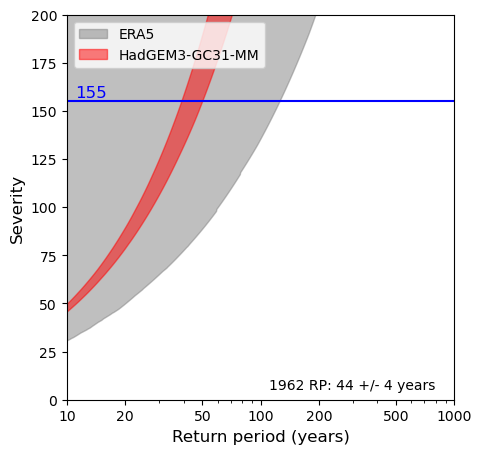

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(5, 5))

# plot the observed return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_obs, 0.025, axis=0).T,
    np.quantile(levels_obs, 0.975, axis=0).T,
    color="gray",
    alpha=0.5,
    label="ERA5",
)

# plot the model return levels
_ = ax.fill_between(
    return_years,
    np.quantile(levels_model, 0.025, axis=0).T,
    np.quantile(levels_model, 0.975, axis=0).T,
    color="red",
    alpha=0.5,
    label="HadGEM3-GC31-MM",
)


# plot the empirical return levels in black
# _ = ax.plot(
#     1 / (model_df_rl["probability"] / 100),
#     model_df_rl["sorted"],
#     color="black",
#     label="Empirical",
# )

# Set up a logarithmic x-axis
ax.set_xscale("log")

# Limit to between 10 and 1000 years
ax.set_xlim(10, 1000)

# Set the xticks at 10, 20, 50, 100, 200, 500, 1000
plt.xticks([10, 20, 50, 100, 200, 500, 1000], ["10", "20", "50", "100", "200", "500", "1000"])

# Set the ylim
ax.set_ylim(0, 200)

# Set the ylabel
ax.set_ylabel("Severity", fontsize=12)

# set the xlabel
ax.set_xlabel("Return period (years)", fontsize=12)

# include the value of the worst obs event with a horizontal line
ax.axhline(
    np.max(df_exceedance_days_obs["severity"]),
    color="blue",
    linestyle="-",
)

# Include text on this line for the value
ax.text(
    11,
    np.max(df_exceedance_days_obs["severity"]) + 2,
    f"{round(np.max(df_exceedance_days_obs['severity']))}",
    color="blue",
    fontsize=12,
)

# Quantify the return level for the worst obs event
model_est_worst_obs = estimate_period(
    return_level=np.max(df_exceedance_days_obs["severity"]),
    loc=model_params_first[0][1],
    scale=model_params_first[0][2],
    shape=model_params_first[0][0],
)

# if model params is not an array
if not isinstance(model_params, np.ndarray):
    model_params = np.array(model_params)

# Same but for the 2.5th percentile
model_est_worst_obs_025 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["severity"]),
    loc=np.percentile(model_params[:, 1], 2.5),
    scale=np.percentile(model_params[:, 2], 2.5),
    shape=np.percentile(model_params[:, 0], 2.5),
)

# Same but for the 97.5th percentile
model_est_worst_obs_975 = estimate_period(
    return_level=np.max(df_exceedance_days_obs["severity"]),
    loc=np.percentile(model_params[:, 1], 97.5),
    scale=np.percentile(model_params[:, 2], 97.5),
    shape=np.percentile(model_params[:, 0], 97.5),
)

# print these values
print(f"Model estimate for worst observed event: {model_est_worst_obs}")
print(f"Model estimate for worst observed event 2.5th percentile: {model_est_worst_obs_025}")
print(f"Model estimate for worst observed event 97.5th percentile: {model_est_worst_obs_975}")

# process into estiates
worst_event = 1 - (model_est_worst_obs / 100)
worst_event_025 = 1 - (model_est_worst_obs_025 / 100)
worst_event_975 = 1 - (model_est_worst_obs_975 / 100)

# Calculate the return period
rp_worst_event = 1 / worst_event
rp_worst_event_025 = 1 / worst_event_025
rp_worst_event_975 = 1 / worst_event_975

# print these values
print(f"Return period for worst observed event: {rp_worst_event}")
print(f"Return period for worst observed event 2.5th percentile: {rp_worst_event_025}")
print(f"Return period for worst observed event 97.5th percentile: {rp_worst_event_975}")

central_95 = abs(rp_worst_event_975 - rp_worst_event_025) / 2

# include a textbox in the top right with the return period of the worst observed event
ax.text(
    0.95,
    0.02,
    f"1962 RP: {round(rp_worst_event)} +/- {round(central_95)} years",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=ax.transAxes,
    fontsize=10,
    # bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

# include a legend in the top left
ax.legend(fontsize=10, loc='upper left')

Now process how the likelihood of extreme events is changing over time.

In [ ]:
max_year

NameError: name 'max_year' is not defined

In [ ]:
%%time

from scipy.stats import genextreme as gev

num_samples = 1000

decades = np.arange(1960, 2030, 10)

decade_years = []

# Set up the decade years
for i, decade in enumerate(decades):
    if i == 0:
        decade_years.append(np.arange(decade, decade + 11))
    else:
        decade_years.append(np.arange(decade + 1, decade + 11))

# Flatten the list of arrays into a single list
flattened_years = np.concatenate(decade_years)

# Filter out the years not in df_model_exceedance_dt["effective_dec_year"].unique()
filtered_years = [year for year in flattened_years if year in df_model_exceedance_dt["effective_dec_year"].unique()]

# Reshape the filtered list back into the original decade structure
filtered_decade_years = []
for i, decade in enumerate(decades):
    if i == 0:
        filtered_decade_years.append(np.array([year for year in filtered_years if 1960 <= year <= 1970]))
    else:
        filtered_decade_years.append(np.array([year for year in filtered_years if decade + 1 <= year <= decade + 10]))

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance_dt["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
# Assuming df_exceedance_days_obs_dt is your DataFrame
max_year = df_exceedance_days_obs_dt.loc[
    df_exceedance_days_obs_dt["no_exceedance_days"].idxmax()
].name

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs_dt["no_exceedance_days"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance_dt[
        df_model_exceedance_dt["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["no_exceedance_days"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  18
The value is:  54.0


7it [05:35, 47.89s/it]

CPU times: user 5min 33s, sys: 6.83 ms, total: 5min 33s
Wall time: 5min 35s


In [ ]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import estimate_period

In [ ]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs_dt["no_exceedance_days"].max()

# find the value for the obs 99th percentile event
obs_99_event = np.percentile(df_exceedance_days_obs_dt["no_exceedance_days"], 99)

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1253.53it/s]


In [ ]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

The year with the greatest no_exceedance_days index is:  1962


Text(0.5, 1.0, 'Return period of the 99th percentile no. exceedance days event (52 days)')

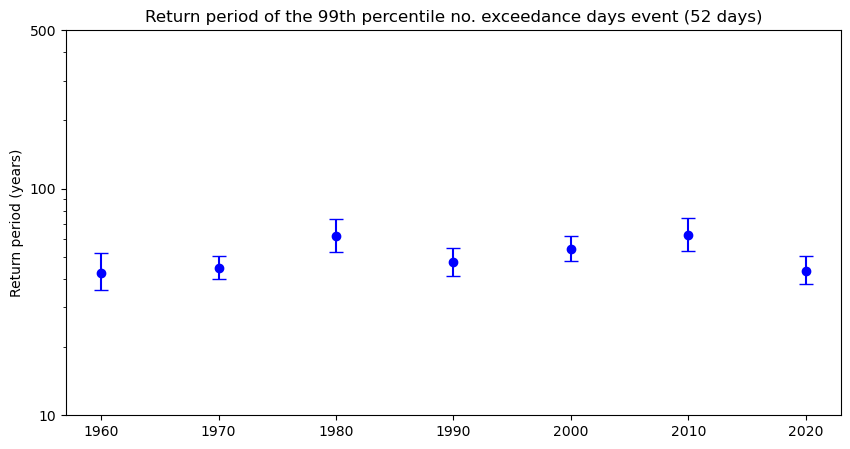

In [ ]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# fit a trend line to the model data
model_trend = np.polyfit(
    model_df_rl["decade"],
    np.log10(model_df_rl["mean_rp (years)"]),
    1,
)

# # plot the trend line as a dashed line
# plt.plot(
#     model_df_rl["decade"],
#     10 ** np.polyval(model_trend, model_df_rl["decade"]),
#     color="blue",
#     linestyle="--",
# )

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 500], ["10", "100", "500"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# print max year
print("The year with the greatest no_exceedance_days index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the 99th percentile no. exceedance days event ({round(obs_99_event)} days)",
)

Text(0.5, 1.0, 'Return period of the worst no. exceedance days event (74, 1962)')

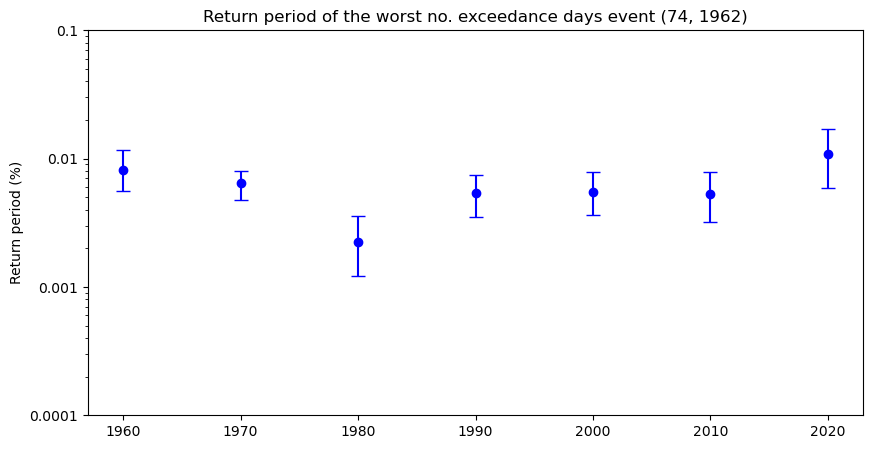

In [ ]:
# Set up the figure
plt.figure(figsize=(10, 5))

# plot scatter of decade vs mean return period (%)
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    yerr=[
        model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"], # lower errors
        model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up the yscale
plt.yscale("log")

# set up the yticks
plt.yticks([0.0001, 0.001, 0.01, 0.1], ["0.0001", "0.001", "0.01", "0.1"])

# set up the ylabel
plt.ylabel("Return period (%)")

# set up the title
plt.title(
    f"Return period of the worst no. exceedance days event ({round(df_exceedance_days_obs['no_exceedance_days'].max())}, {max_year})"
)

Now for changes in severity over time.

In [ ]:
%%time

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["severity"].idxmax()
].name

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["severity"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["severity"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  1962
The value is:  155.33362949428323


7it [05:06, 43.80s/it]

CPU times: user 5min 3s, sys: 722 ms, total: 5min 4s
Wall time: 5min 6s


In [ ]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["severity"].max()

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_worst_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1253.10it/s]


In [ ]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

The year with the greatest severity index is:  1962


Text(0.5, 1.0, 'Return period of the worst severity index event (155, 1962)')

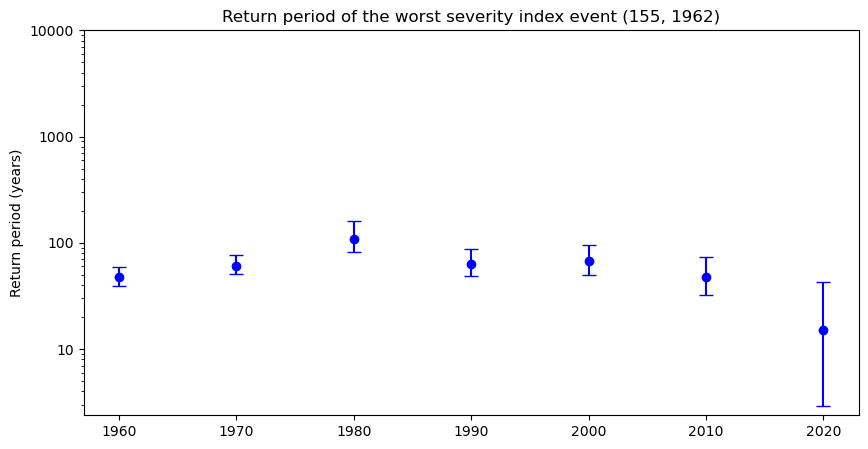

In [ ]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 1000, 10000], ["10", "100", "1000", "10000"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["severity"].idxmax()
].name

# print max year
print("The year with the greatest severity index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the worst severity index event ({round(df_exceedance_days_obs['severity'].max())}, {max_year})"
)

Text(0.5, 1.0, 'Return period of the worst severity event (155, 1962)')

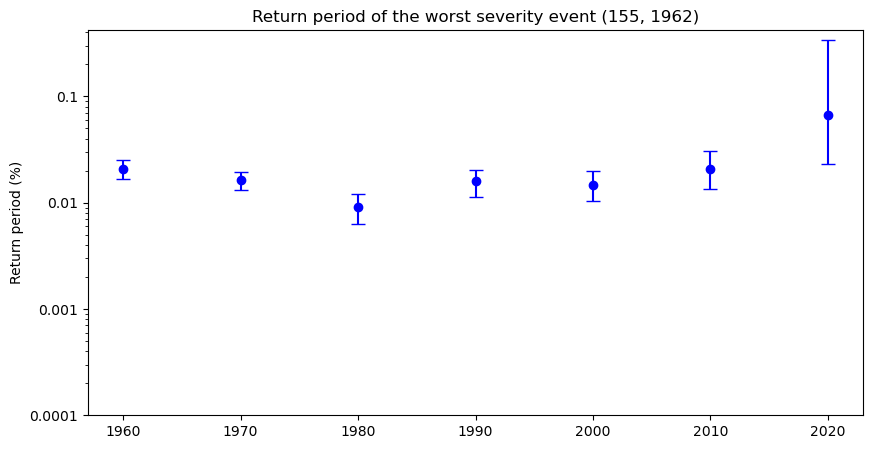

In [ ]:
# Set up the figure
plt.figure(figsize=(10, 5))

# plot scatter of decade vs mean return period (%)
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (%)"],
    yerr=[
        model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"], # lower errors
        model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# set up the yscale
plt.yscale("log")

# set up the yticks
plt.yticks([0.0001, 0.001, 0.01, 0.1], ["0.0001", "0.001", "0.01", "0.1"])

# set up the ylabel
plt.ylabel("Return period (%)")

# set up the title
plt.title(
    f"Return period of the worst severity event ({round(df_exceedance_days_obs['severity'].max())}, {max_year})"
)

Now we should detrend demand and then repeat. It's weird that there is this trend.

First plot the time series to explore the trend.

In [ ]:
df_model_ondjfm.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719


In [ ]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

In [ ]:
df_model_ondjfm_wyear.head()

,init_year,member,lead,data,data_c,hdd,cdd,UK_demand,winter_year
330,1960,1,331,283.344633,10.194633,5.305367,0,39.022425,1
331,1960,1,332,284.247110,11.097110,4.402890,0,38.347726,1
332,1960,1,333,284.948156,11.798156,3.701844,0,37.823617,1
333,1960,1,334,284.529038,11.379038,4.120962,0,38.136953,1
334,1960,1,335,284.921268,11.771268,3.728732,0,37.843719,1


In [ ]:
# include effective dec year
df_model_ondjfm_wyear["effective_dec_year"] = df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]

In [ ]:
import scipy.stats as stats

# calculate the slopes
# create an empty array to store the values of slope and intercept
slopes = np.zeros([len(df_model_ondjfm_wyear["member"].unique()), len(df_model_ondjfm_wyear["winter_year"].unique())])
intercepts = np.zeros([len(df_model_ondjfm_wyear["member"].unique()), len(df_model_ondjfm_wyear["winter_year"].unique())])

# set up the unique members
members = df_model_ondjfm_wyear["member"].unique()

# set up the unique leads
leads = df_model_ondjfm_wyear["winter_year"].unique()

# loop over the unique members
for m, member in enumerate(members):
    for l, winter_year in enumerate(leads):
        # Extract the data for the member and the winter_year
        model_data_this = df_model_ondjfm_wyear[
            (df_model_ondjfm_wyear["member"] == member) & (df_model_ondjfm_wyear["winter_year"] == winter_year)
        ]

        # Fit a linear trend to the model data
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            model_data_this["effective_dec_year"], model_data_this["UK_demand"]
        )

        # Store the slope and intercept
        slopes[m, l] = slope
        intercepts[m, l] = intercept

# flatten the slopes
slopes_flat = slopes.flatten()
intercepts_flat = intercepts.flatten()

# print the mean of the slopes_flat
print(f"Mean of slopes_flat: {np.mean(slopes_flat)}")

# print the 2.5% and 97.5% percentiles of the slopes_flat
print(f"2.5% percentile of slopes_flat: {np.percentile(slopes_flat, 2.5)}")
print(f"97.5% percentile of slopes_flat: {np.percentile(slopes_flat, 97.5)}")

Mean of slopes_flat: -0.022468317442175006
2.5% percentile of slopes_flat: -0.03072795292586674
97.5% percentile of slopes_flat: -0.014280818146399655


In [ ]:
# now try pivoting the model data around the final point

# compute the linear trend
# as the mean of the slopes_flat and intercepts_flat
# for all the member and lead combinations
trend_line = np.mean(slopes_flat) *df_model_ondjfm_wyear["effective_dec_year"] + np.mean(intercepts_flat)

# Calculate the value of the trend line at the final point
trend_line_2017 = np.mean(slopes_flat) *df_model_ondjfm_wyear["effective_dec_year"].iloc[-1] + np.mean(intercepts_flat)

# Detrend the data by subtracting the trend line and adding back the final point value
df_model_ondjfm_wyear['UK_demand_dt'] =df_model_ondjfm_wyear['UK_demand'] - trend_line + trend_line_2017

In [ ]:
# # remove this same trend form the obs data
# trend_line_interp = np.interp(
#     df_obs_tas.inde

In [ ]:
trend_line_2017

np.float64(42.12910504577425)

<Axes: xlabel='time'>

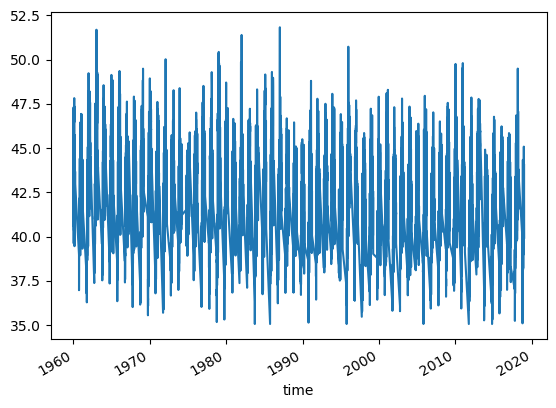

In [ ]:
df_obs_tas["UK_demand"].plot()

In [ ]:
type(df_model_ondjfm_wyear["effective_dec_year"])

pandas.core.series.Series

In [ ]:
# format the effective_dec_year to a datetime object
df_model_ondjfm_wyear["effective_dec_year"] = pd.to_datetime(df_model_ondjfm_wyear["effective_dec_year"], format="%Y")

Text(0.5, 1.0, 'UK ONDJFM 10m wind speed 1979-2017')

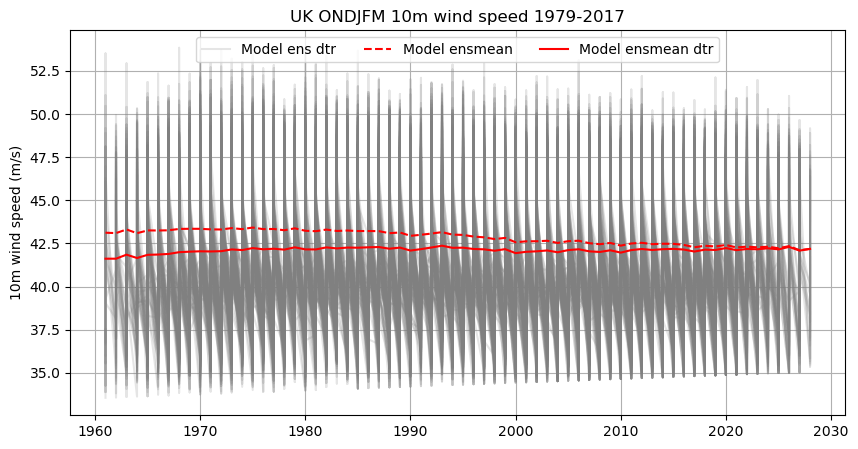

In [ ]:
# set up a figure of size 10, 5
plt.figure(figsize=(10, 5))

# include gridlines and ticks
plt.grid(True)

# loop over and plot all of the unique member and winter_year combinations
for member in df_model_ondjfm_wyear["member"].unique():
    for winter_year in df_model_ondjfm_wyear["winter_year"].unique():
        
        model_data_this = df_model_ondjfm_wyear[
            (df_model_ondjfm_wyear["member"] == member) & (df_model_ondjfm_wyear["winter_year"] == winter_year)
        ]

        # if this is the first member and winter_year combination
        # include a label
        if (member == df_model_ondjfm_wyear["member"].unique()[0]) & (winter_year == df_model_ondjfm_wyear["winter_year"].unique()[0]):
            plt.plot(
                model_data_this["effective_dec_year"],
                model_data_this["UK_demand_dt"],
                color="gray",
                alpha=0.2,
                label="Model ens dtr",
            )

        plt.plot(
            model_data_this["effective_dec_year"],
            model_data_this["UK_demand_dt"],
            color="gray",
            alpha=0.2,
        )

# plot the ensemble mean of the model data (avg over member and winter_year)
model_df_avg = df_model_ondjfm_wyear.groupby("effective_dec_year").mean()

# reset the index
model_df_avg = model_df_avg.reset_index()

# plot the model ensmean not detrended
plt.plot(
    model_df_avg["effective_dec_year"],
    model_df_avg["UK_demand"],
    label="Model ensmean",
    color="red",
    linestyle="--",
)

# plot the model ensmean detrended
plt.plot(
    model_df_avg["effective_dec_year"],
    model_df_avg["UK_demand_dt"],
    label="Model ensmean dtr",
    color="red",
)

# # plot the observed data not detrended
# plt.plot(
#     df_obs_tas.index,
#     df_obs_tas["UK_demand"],
#     label="Obs",
#     color="black",
#     linestyle="--",
# )

# # plot the observed data detrended
# plt.plot(
#     df_obs_tas.index,
#     df_obs_tas["UK_demand_dt"],
#     label="Obs dtr",
#     color="black",
# )

# # plot the highest value for tas mon in black as a horizontal dashed line
# plt.axhline(y=df_obs_tas['UK_demand'].max(), color='black', linestyle='--', linewidth=0.8)

# # plot the highest value for tas mon in black as a horizontal line
# plt.axhline(y=df_obs_tas['UK_demand_dt'].max(), color='black', linewidth=0.8)

# include the legend centred at the top of the plot
plt.legend(loc="upper center", ncol=3)

# include a ylabel
plt.ylabel("10m wind speed (m/s)")

# include the title
plt.title("UK ONDJFM 10m wind speed 1979-2017")